# Data Privacy and Leakage Evaluation

In [153]:
from evaluation import *
from metrics import *
from attacks import  *
from data.data_utils import get_sequences_from_file, set_seed
import json

SOURCE_DATA_FIGURES = 'figures/source_data'
PRIVACY_FIGURES = 'figures/generated_data/privacy_eval'

data_size = 'medium'
eps=1
TRAIN_DATA = f'data/sources/json/{data_size}/train_gts_with_pop.json' 
HOLDOUT_DATA = f'data/sources/json/{data_size}/holdout_gts_with_pop.json'
VAL_DATA = f'data/sources/json/{data_size}/val_gts_with_pop.json'

HIGH_RISK_DATA = f'data/sources/json/{data_size}/all_rare_genotypes_{data_size}_chr22.json'
HIGH_RISK_GTS = f'data/sources/json/{data_size}/rare_genotypes_{data_size}_chr22.json'
HIGH_RISK_SAMPLES_LIST = f'data/sources/json/{data_size}/sample_ids_per_dataset.json'

# saved_mingpt = f'models/saved/minGPT/minGPT_noDP_{data_size}.pth'
saved_mingpt = f'models/saved/minGPT/minGPT_noDP_{data_size}.pth'
# saved_mingpt_dp = f'models/saved/minGPT/DP/minGPT_DP_{data_size}.pth'
saved_mingpt_dp = f'models/saved/minGPT/DP/minGPT_DP_{data_size}_eps{eps}.pth'
saved_gpt2 = f'models/saved/GPT'
saved_gpt2_dp = f'models/saved/GPT/DP'

set_seed(42)

import warnings
warnings.simplefilter("ignore", UserWarning)

In [154]:
# JSON generated genotype files
JSON_GENERATED_DATAPATH = 'data/generated/json'

random_benchmark_gts = f'{JSON_GENERATED_DATAPATH}/random/rand_corpus_chr22_50ids_1000muts.json' 
gpt_pretrained_gts = f'{JSON_GENERATED_DATAPATH}/baseline_gpt2_pretrained.json'

mingpt_gts = f'{JSON_GENERATED_DATAPATH}/minGPT/mingpt_nodp.json'
mingpt_dp_gts = f'{JSON_GENERATED_DATAPATH}/minGPT/mingpt_dp.json'
gpt_gts = f'{JSON_GENERATED_DATAPATH}/GPT/gpt_dp.json'
gpt_dp_gts = f'{JSON_GENERATED_DATAPATH}/GPT/gpt_nodp.json'

In [155]:
training_samples = get_sequences_from_file(TRAIN_DATA)
training_gts = [gt['genotypes'] for gt in training_samples]
original_sample_sequences, _, _ = get_valid_sequences(training_gts, sample_wise=True, 
                                                    has_sample_names=True)
print(f'Loaded {len(original_sample_sequences)} original samples')

holdout_samples = get_sequences_from_file(HOLDOUT_DATA)
holdout_gts = [gt['genotypes'] for gt in holdout_samples]
holdout_sample_sequences, _, _ = get_valid_sequences(holdout_gts, sample_wise=True, 
                                                    has_sample_names=True)
print(f'Loaded {len(holdout_sample_sequences)} holdout samples')

Loaded 1752 original samples
Loaded 376 holdout samples


# 1. Original 1000GP Data

___

## High Risk Sample Genotypes

In [156]:
with open(HIGH_RISK_GTS, 'r') as f:
    high_risk_gts = json.load(f)
rare_muts_per_sample = {sample: len(gt.split(' ')) for sample, gt in high_risk_gts.items()}
with open(HIGH_RISK_DATA, 'r') as f:
    rare_genotypes = json.load(f)
rare_gts_per_sample = {sample: len(gt.split(' ')) for sample, gt in rare_genotypes.items()}

muts_diff = [rare_gts - rare_muts for rare_gts, rare_muts in zip(rare_gts_per_sample.values(), rare_muts_per_sample.values())]

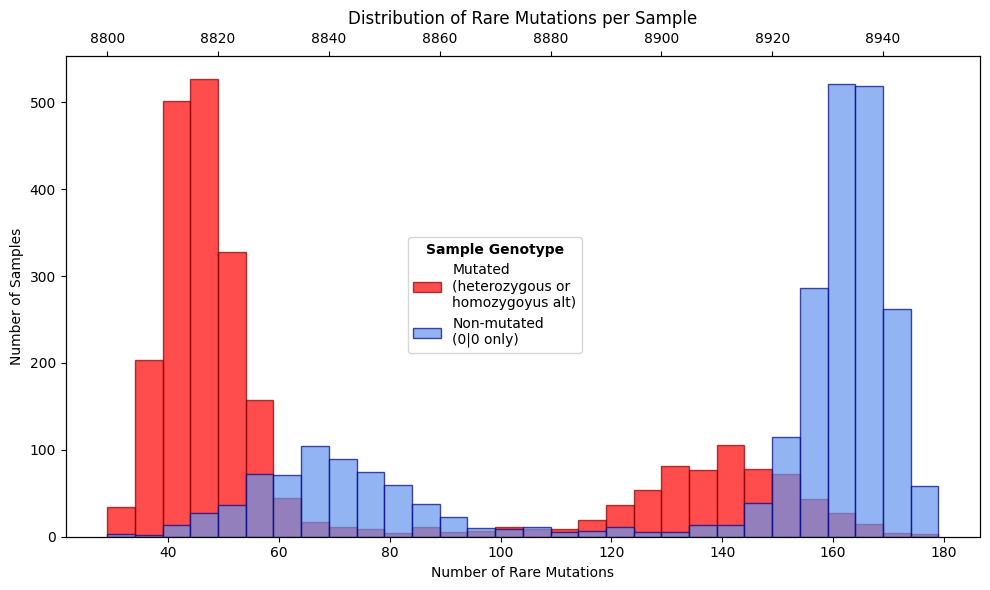

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(rare_muts_per_sample.values(), bins=30,
        color='red', edgecolor='maroon', alpha=0.7,
        label='Mutated\n(heterozygous or\nhomozygoyus alt)')
ax2 = ax.twiny()
ax2.hist(muts_diff, bins=30, 
         color='cornflowerblue', edgecolor='navy', alpha=0.7,
         label='Non-mutated\n(0|0 only)')

ax.set_xlabel('Number of Rare Mutations')
ax.set_ylabel('Number of Samples')

plt.title('Distribution of Rare Mutations per Sample')
fig.legend(loc='center', title='Sample Genotype', title_fontproperties={'weight':'bold'})
plt.tight_layout()
plt.savefig('figures/source_data/rare_mutations_distribution.pdf', format='pdf')
plt.show()

In [157]:
with open(HIGH_RISK_SAMPLES_LIST, 'r') as f:
    high_risk_samples = json.load(f)

high_risk_train_gts = {sample: seq for sample, seq in rare_genotypes.items() if sample in high_risk_samples['train']}
high_risk_holdout_gts = {sample: seq for sample, seq in rare_genotypes.items() if sample in high_risk_samples['holdout']}

In [158]:
high_risk_sequences_train, _, _ = get_valid_sequences(list(high_risk_train_gts.values()), sample_wise=True, 
                                                    has_sample_names=False)
print(f'Loaded {len(high_risk_sequences_train)} original samples')

high_risk_sequences_holdout, _, _ = get_valid_sequences(list(high_risk_holdout_gts.values()), sample_wise=True, 
                                                    has_sample_names=False)
print(f'Loaded {len(high_risk_sequences_holdout)} holdout samples')

Loaded 1752 original samples
Loaded 376 holdout samples


In [159]:
with open(f'data/sources/json/{data_size}/high_risk_profiles_{data_size}_chr22.json', 'r') as f:
        rare_sample_gts = json.load(f)

high_risk_train_samples = {sample: seq for sample, seq in rare_sample_gts.items() if sample in high_risk_samples['train'] and seq != ''}
high_risk_holdout_samples = {sample: seq for sample, seq in rare_sample_gts.items() if sample in high_risk_samples['holdout'] and seq != ''}

high_risk_samples_train, _, _ = get_valid_sequences(list(high_risk_train_samples.values()), sample_wise=True, 
                                                    has_sample_names=False)
print(f'Loaded {len(high_risk_samples_train)} high-risk original samples')

high_risk_samples_holdout, _, _ = get_valid_sequences(list(high_risk_holdout_samples.values()), sample_wise=True, 
                                                    has_sample_names=False)
print(f'Loaded {len(high_risk_samples_holdout)} high-risk holdout samples')

Loaded 102 high-risk original samples
Loaded 27 high-risk holdout samples


In [160]:
def get_train_test_sequences(test_rare_only=False,
                            test_high_risk=False,
                            test_common=False, 
                            num_samples=20):
    if test_rare_only:
        train_seq, test_seq = ([' '.join(s) for s in high_risk_sequences_train[:num_samples]],
                               [' '.join(s) for s in high_risk_sequences_holdout[:num_samples]])
    elif test_high_risk:
        train_seq, test_seq = ([' '.join(s) for s in high_risk_samples_train[:num_samples]],
                            [' '.join(s) for s in high_risk_samples_holdout[:num_samples]])
    elif test_common:
        train_seq, test_seq = ([' '.join(s) for s in original_sample_sequences[:num_samples] if s not in high_risk_sequences_train],
                           [' '.join(s) for s in holdout_sample_sequences[:num_samples] if s not in high_risk_sequences_holdout])
    else:
        # randomly chosen samples
        train_seq, test_seq = ([' '.join(s) for s in original_sample_sequences[:num_samples]],
                           [' '.join(s) for s in holdout_sample_sequences[:num_samples]])
    return train_seq, test_seq

# 2. minGPT Synthetic Data

In [ ]:
# from models.MinGPT import *
from models.MinGPT import *
from models.tokenizers import RegexTokenizer

regex_tokenizer = RegexTokenizer()
regex_tokenizer.load()

GPT_SPECIAL_TOKENS = {'<START_SAMPLE>': 4096,
                    '<END_SAMPLE>': 4097,
                    '<MUT_SEP>': 4098,
                    '<START_ID>': 4099,
                    '<END_ID>': 4100,
                    '<START_POP>': 4101,
                    '<END_POP>': 4102,
                    '<PAD>': 4103,
                    '<UNK>': 4104}
regex_tokenizer.register_special_tokens(GPT_SPECIAL_TOKENS)
regex_tokenizer.special_tokens = GPT_SPECIAL_TOKENS

In [162]:
# load saved minGPT model (no DP)
mingpt = MinGPT.from_pretrained(saved_mingpt)
print(mingpt)

MinGPT(
  (transformer): ModuleDict(
    (wte): Embedding(4104, 384)
    (wpe): Embedding(4676, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=4104, bias=False)
)


In [6]:
# load saved minGPT model (with DP)
mingpt_dp = MinGPT.from_pretrained(saved_mingpt_dp)
print(mingpt_dp)

MinGPT(
  (transformer): ModuleDict(
    (wte): Embedding(4104, 384)
    (wpe): Embedding(4676, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=4104, bias=False)
)


___

In [ ]:
mingpt_gts = json.load(open('data/generated/json/minGPT/mingpt_nodp.json', 'r'))
privacy_mingpt.synthetic_gts = mingpt_gts

In [150]:
privacy_mingpt.rare_variant_leakage(num_samples=20)

Analyzing 954 mutations:   0%|          | 0/20 [00:00<?, ?it/s]

___

## 2.A Prompt-based attacks

In [75]:
from importlib import reload

import metrics
reload(metrics)
from metrics import *

import attacks
reload(attacks)
from attacks import *

import evaluation
reload(evaluation)
from evaluation import *

In [43]:
def plot_sample_distances_by_prompt_length(distances, figsize=(10, 6), save_path=None, dist_name='cosine', **kwargs):
        fig, axs = plt.subplots(figsize=figsize, layout='constrained')
        title=kwargs.get('title', f'Comparison of Sample {dist_name} Distances by Prompt Length')

        color_selection = np.arange(len(distances))
        cmap = mpl.colormaps[kwargs.get('cmap', 'tab20c')] # ['Pastel1']
        colors = cmap(np.linspace(0, 1, len(color_selection)))
        
        k = list(distances.keys())[0]
        print(len(distances[k][0]))
        x_values = np.arange(len(distances[k][0]))
        bar_width = 1. / len(distances) - 0.05 # deduct some space between bars
        shift_ratio = 0

        labels = kwargs.get('labels', list(distances.keys()))

        plot_error_bar = kwargs.get('plot_error_bar', False)
        plot_max = kwargs.get('plot_max', not plot_error_bar)
                
        if 'x_ticks' in kwargs:
            x_ticks = kwargs['x_ticks']
            axs.set_xticks([i for i in range(len(x_ticks))])
            axs.set_xticklabels(x_ticks)
        else:
            plt.xticks([])

        for i, (prompt_type, distances_by_length) in enumerate(distances.items()):
            # print(prompt_type, distances_by_length)
            offset = bar_width * shift_ratio
            reduce_ax = 0
            mean = np.mean(distances_by_length, axis=reduce_ax)
            print(distances_by_length)
            if len(distances_by_length) > 1:
                # different prompt lengths
                if plot_error_bar:
                    yerr = [mean - np.min(distances_by_length, axis=reduce_ax), np.max(distances_by_length, axis=reduce_ax) - mean]
                    distances_by_length = mean
                else:
                    yerr = [np.zeros_like(distances_by_length), np.zeros_like(distances_by_length)]
                    if isinstance(distances_by_length, list):
                        if plot_max:
                            distances_by_length = np.max(distances_by_length, axis=reduce_ax)
                        else:
                            distances_by_length = np.mean(distances_by_length, axis=reduce_ax)
                print('\n', yerr, distances_by_length)
                if plot_error_bar:
                    axs.bar(x_values + offset, distances_by_length, bar_width, 
                            label=labels[i], color=colors[i], yerr=yerr)
                else:
                    axs.bar(x_values + offset, distances_by_length, bar_width, 
                            label=labels[i], color=colors[i])
                    # axs.bar_label('{:.2%}'.format(metric_bar.value), padding=3)
                    # axs.bar_label(metric_bar, padding=5)
            else:
                distances_by_length = np.mean(distances_by_length, axis=reduce_ax)
                axs.bar(x_values + offset, distances_by_length, bar_width, 
                        label=labels[i], color=colors[i])
            shift_ratio += 1
        
        if kwargs.get('set_max_y', False):
            # set max y-axis limit
            axs.set_ylim(top=1.0)

        plt.title(title)
        plt.xlabel('Sample')
        plt.ylabel('Distance')
        if len(distances) > 1 and kwargs.get('show_legend', True): 
            legend_title = kwargs.get('legend_title', 'Generation Model')
            bbox_to_anchor = kwargs.get('bbox_to_anchor', (0.8, 0.6))
            axs.legend(title=legend_title, title_fontproperties={'weight':'bold'},
                        bbox_to_anchor=bbox_to_anchor)

        if save_path:
            plt.savefig(f'{save_path}.pdf', format='pdf')
        plt.show()

In [62]:
privacy_mingpt = PrivacyEval(
                model = mingpt,
                tokenizer = regex_tokenizer,
                ref_genomes = TRAIN_DATA,
                holdout_genomes = HOLDOUT_DATA,
                device='cpu',
                plot=True,
                save_plot=True,
                default_metric='cosine')

print('Starting prompt-based information leakage attack...')
privacy_mingpt.prompt_based_il_attack(rounds=3, return_avg=False, prompt_types=['training', 'holdout', 'random'], extract_features=False)

print('Starting prompt-length based information leakage attack...')
privacy_mingpt.prompt_length_il_attack(max_prompt_length=5, rounds=3, return_avg=False, extract_features=False)


Starting prompt-based information leakage attack...
Extracting token-based distances using cosine metric...


Prompting for random data: 100%|██████████| 3/3 [04:12<00:00, 84.14s/it, Generating sample 3]  


Starting prompt-length based information leakage attack...
Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [02:43<00:00, 81.57s/it, Generating sample 3] 


Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [02:42<00:00, 81.07s/it, Generating sample 3] 


Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [02:39<00:00, 79.75s/it, Generating sample 3] 


Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [02:40<00:00, 80.40s/it, Generating sample 3] 


Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [02:42<00:00, 81.22s/it, Generating sample 3] 


In [63]:
privacy_mingpt_dp = PrivacyEval(
                model = mingpt_dp,
                tokenizer = regex_tokenizer,
                ref_genomes = TRAIN_DATA,
                holdout_genomes = HOLDOUT_DATA,
                device='cpu',
                plot=True,
                save_plot=True,
                default_metric='cosine')

print('Starting prompt-based information leakage attack...')
privacy_mingpt_dp.prompt_based_il_attack(rounds=3, return_avg=False, prompt_types=['training', 'holdout', 'random'], extract_features=False)

print('Starting prompt-length based information leakage attack...')
privacy_mingpt_dp.prompt_length_il_attack(max_prompt_length=5, rounds=3, return_avg=False, extract_features=False)

Starting prompt-based information leakage attack...
Extracting token-based distances using cosine metric...


Prompting for random data: 100%|██████████| 3/3 [04:09<00:00, 83.25s/it, Generating sample 3]  


Starting prompt-length based information leakage attack...
Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [02:44<00:00, 82.07s/it, Generating sample 3] 


Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [02:56<00:00, 88.45s/it, Generating sample 3] 


Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [02:58<00:00, 89.06s/it, Generating sample 3] 


Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [03:01<00:00, 90.72s/it, Generating sample 3] 


Extracting token-based distances using cosine metric...


Prompting for holdout data: 100%|██████████| 2/2 [03:12<00:00, 96.08s/it, Generating sample 3] 


3
[[0.2767226421021337, 0.25720892197654777, 0.25903272459374116]]
[[0.29668549444583114, 0.265708908907319, 0.24242372475741525]]
[[0.2696206089272424, 0.23345152695522942, 0.25028680138443005]]
[[0.31675662065451526, 0.23420491444864389, 0.2545898892708883]]
[[0.5902141532001537, 0.6796877163454413, 0.4649906432034544]]
[[0.4831934925205117, 0.5312296756148053, 0.598531656866188]]


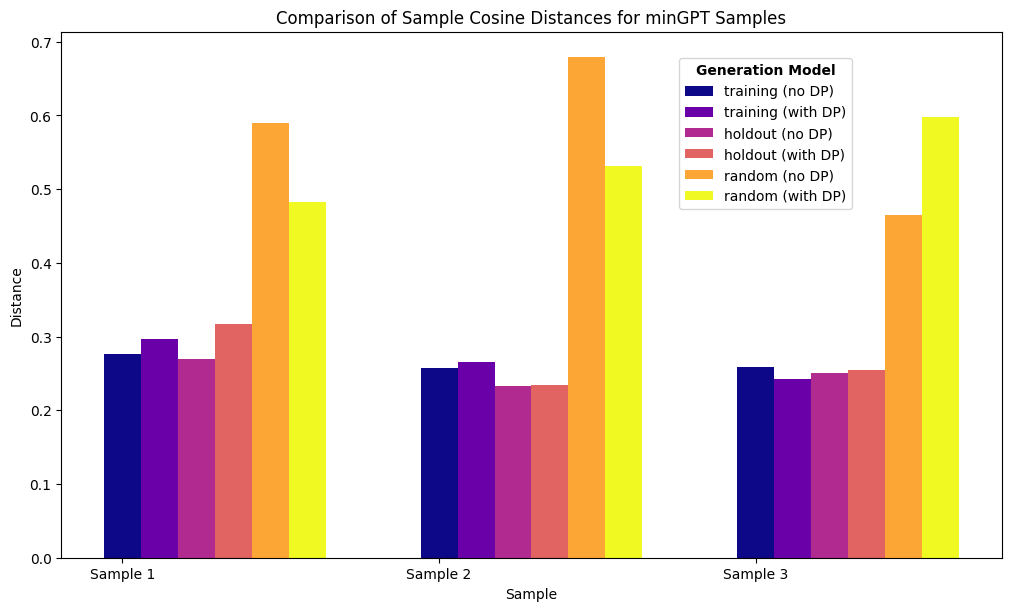

In [73]:
merged_distances = {'training_noDP': privacy_mingpt.model_privacy['prompt_based_il']['training'],
                    'training_withDP': privacy_mingpt_dp.model_privacy['prompt_based_il']['training'],
                    'holdout_noDP': privacy_mingpt.model_privacy['prompt_based_il']['holdout'],
                    'holdout_withDP': privacy_mingpt_dp.model_privacy['prompt_based_il']['holdout'],
                    'random_noDP': privacy_mingpt.model_privacy['prompt_based_il']['random'],
                    'random_withDP': privacy_mingpt_dp.model_privacy['prompt_based_il']['random']}
plot_sample_distances_by_prompt_length(merged_distances,
                                       bbox_to_anchor=(0.65, 0.65),
                                       cmap='plasma',
                                       labels=['training (no DP)', 'training (with DP)',
                                               'holdout (no DP)', 'holdout (with DP)',
                                               'random (no DP)', 'random (with DP)'],
                                       title='Comparison of Sample Cosine Distances for minGPT Samples',
                                       x_ticks=[f'Sample {i+1}' for i in range(len(privacy_mingpt.model_privacy['prompt_based_il']['training'][0]))],
                                       save_path=f'figures/generated_data/distances/mingpt_prompt_based_il_comparison_dp_eps{eps}')

In [130]:
print('Starting prompt-based information leakage attack by feature extraction...')
privacy_mingpt.prompt_based_il_attack(rounds=3, return_avg=False, 
                                    prompt_types=['training', 'holdout', 'random'], 
                                    extract_features=True)

privacy_mingpt_dp.prompt_based_il_attack(rounds=3, return_avg=False, 
                                         prompt_types=['training', 'holdout', 'random'], 
                                         extract_features=True)

Starting prompt-based information leakage attack by feature extraction...
Extracting feature-based distances using cosine metric...


Prompting for random data: 100%|██████████| 3/3 [04:15<00:00, 85.08s/it, Generating sample 3]  


Extracting feature-based distances using cosine metric...


Prompting for random data: 100%|██████████| 3/3 [04:20<00:00, 86.68s/it, Generating sample 3]  


3
[[0.07740439709350577, 0.005783504348163437, 0.04948684959506355]]
[[0.0016909484541972608, 0.0016722892543207246, 0.0018093309673895552]]
[[0.034469138704532054, 0.003925945562918143, 0.0006658073055960667]]
[[0.0020240947238978624, 0.0033002600047569164, 0.0034898859084574463]]
[[0.6296571775461564, 0.677904413798355, 0.7174984394657032]]
[[0.7261364706524596, 0.737024555034286, 0.71096627529564]]


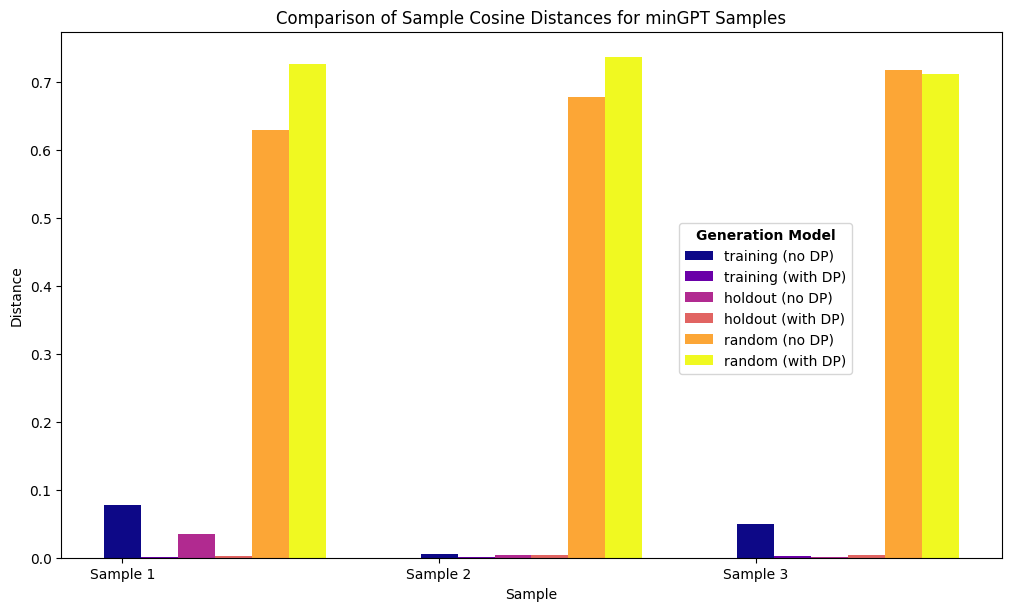

In [131]:
merged_distances_by_feats = {'training_noDP': privacy_mingpt.model_privacy['prompt_based_il']['training'],
                    'training_withDP': privacy_mingpt_dp.model_privacy['prompt_based_il']['training'],
                    'holdout_noDP': privacy_mingpt.model_privacy['prompt_based_il']['holdout'],
                    'holdout_withDP': privacy_mingpt_dp.model_privacy['prompt_based_il']['holdout'],
                    'random_noDP': privacy_mingpt.model_privacy['prompt_based_il']['random'],
                    'random_withDP': privacy_mingpt_dp.model_privacy['prompt_based_il']['random']}
plot_sample_distances_by_prompt_length(merged_distances_by_feats,
                                       bbox_to_anchor=(0.65, 0.65),
                                       cmap='plasma',
                                       labels=['training (no DP)', 'training (with DP)',
                                               'holdout (no DP)', 'holdout (with DP)',
                                               'random (no DP)', 'random (with DP)'],
                                       title='Comparison of Sample Cosine Distances for minGPT Samples',
                                       x_ticks=[f'Sample {i+1}' for i in range(len(privacy_mingpt.model_privacy['prompt_based_il']['training'][0]))],
                                       save_path=f'figures/generated_data/distances/distances_minGPT_comparison_features')

In [151]:
mingpt_gts = json.load(open('data/generated/json/minGPT/mingpt_nodp.json', 'r'))
privacy_mingpt.synthetic_gts = mingpt_gts

privacy_mingpt.rare_variant_leakage(num_samples=20)
print(privacy_mingpt)

print(privacy_mingpt)

Privacy Evaluation for MinGPT
prompt_based_il:
- training: [[0.07740439709350577, 0.005783504348163437, 0.04948684959506355]]
- holdout: [[0.034469138704532054, 0.003925945562918143, 0.0006658073055960667]]
- random: [[0.6296571775461564, 0.677904413798355, 0.7174984394657032]]
----------> Asserts if the model leaks information about samples in the training dataset by prompting it with training and holdout mutations

prompt_length_based_il:
- training: [[[0.29143335427693007, 0.40021445896081353, 0.24608332592319992]], [[0.22921307413330827, 0.2610022470433071, 0.22279770053552816]], [[0.2838559301368012, 0.27520747130156675, 0.20168489666136358]], [[0.3153074059252807, 0.2396212560870693, 0.1949580075466073]], [[0.15110825443602982, 0.264807502896087, 0.23230973266085042]]]
- holdout: [[[0.20897492345947621, 0.40922000576212236, 0.2391556512582781]], [[0.35431880427959106, 0.2273949704516799, 0.2746726277366299]], [[0.20067751586976568, 0.22652339104518615, 0.25117280811786125]], [[0.

In [152]:
mingpt_dp_gts = json.load(open('data/generated/json/minGPT/mingpt_dp.json', 'r'))
privacy_mingpt_dp.synthetic_gts = mingpt_dp_gts

privacy_mingpt_dp.rare_variant_leakage(num_samples=20)
print(privacy_mingpt_dp)

Analyzing 2696 mutations: 100%|██████████| 20/20 [05:11<00:00, 15.57s/it, Found 2217 rare mutations (of which 3 leaked non-ref) and 143 common mutations (of which 15 leaked non-ref) and 2553 unseen mutations]

Privacy Evaluation for MinGPT
prompt_based_il:
- training: [[0.0016909484541972608, 0.0016722892543207246, 0.0018093309673895552]]
- holdout: [[0.0020240947238978624, 0.0033002600047569164, 0.0034898859084574463]]
- random: [[0.7261364706524596, 0.737024555034286, 0.71096627529564]]
----------> Asserts if the model leaks information about samples in the training dataset by prompting it with training and holdout mutations

prompt_length_based_il:
- training: [[[0.22979424088252842, 0.2661047114140941, 0.21266593152177915]], [[0.27160210765777715, 0.28906663460559623, 0.2545568177020372]], [[0.310932324420613, 0.2946944991191567, 0.22122452963706485]], [[0.3149237159205376, 0.32064142053002975, 0.28650533692216373]], [[0.2600799383765332, 0.2517352848057852, 0.24983935718924766]]]
- holdout: [[[0.30388623771918377, 0.2597312186931281, 0.24136672773271028]], [[0.2802518216068677, 0.2965449595462132, 0.30907658631234447]], [[0.2798638949150657, 0.324977433776351, 0.2979656909224714]], [[0.

___

## 2.B Membership Inference

In [147]:
train_seq, test_seq = get_train_test_sequences(test_rare_only=False, 
                                               test_high_risk=False, 
                                               num_samples=20)

results = run_blackbox_mia(mingpt, regex_tokenizer, train_seq, test_seq, 
                           include_genomic_features=False,
                           title="minGPT MIA Result")
results_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, 
                              include_genomic_features=False,
                              title="minGPT DP MIA Results")

Extracting model-based features from 20 samples:   0%|          | 0/20 [00:01<?, ?it/s, Processing tokens (0 to 100)]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Extracting model-based features from 20 samples: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it, Calculating Metrics]               
/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 31.95it/s]



Privacy Assessment: Membership Inference
Risk Level: MODERATE
Highest AUC: 0.6600
Attack Advantage: 0.1600

Attacks Results:
- THRESHOLD: AUC=0.5000, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- LOGISTIC: AUC=0.6600, Accuracy=0.5500, Precision=0.5667, Recall=0.5500, F-Score=0.5200
- RF: AUC=0.4450, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.5000
- KNN: AUC=0.2600, Accuracy=0.3500, Precision=0.2059, Recall=0.3500, F-Score=0.2593



Extracting model-based features from 20 samples:   0%|          | 0/20 [00:00<?, ?it/s, Processing tokens (0 to 100)]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Extracting model-based features from 20 samples: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it, Calculating Metrics]               
/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 27.21it/s]



Privacy Assessment: Membership Inference
Risk Level: LOW
Highest AUC: 0.5300
Attack Advantage: 0.0300

Attacks Results:
- THRESHOLD: AUC=0.5000, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- LOGISTIC: AUC=0.5300, Accuracy=0.5500, Precision=0.5505, Recall=0.5500, F-Score=0.5489
- RF: AUC=0.3750, Accuracy=0.4000, Precision=0.3810, Recall=0.4000, F-Score=0.3750
- KNN: AUC=0.3700, Accuracy=0.4500, Precision=0.4451, Recall=0.4500, F-Score=0.4373



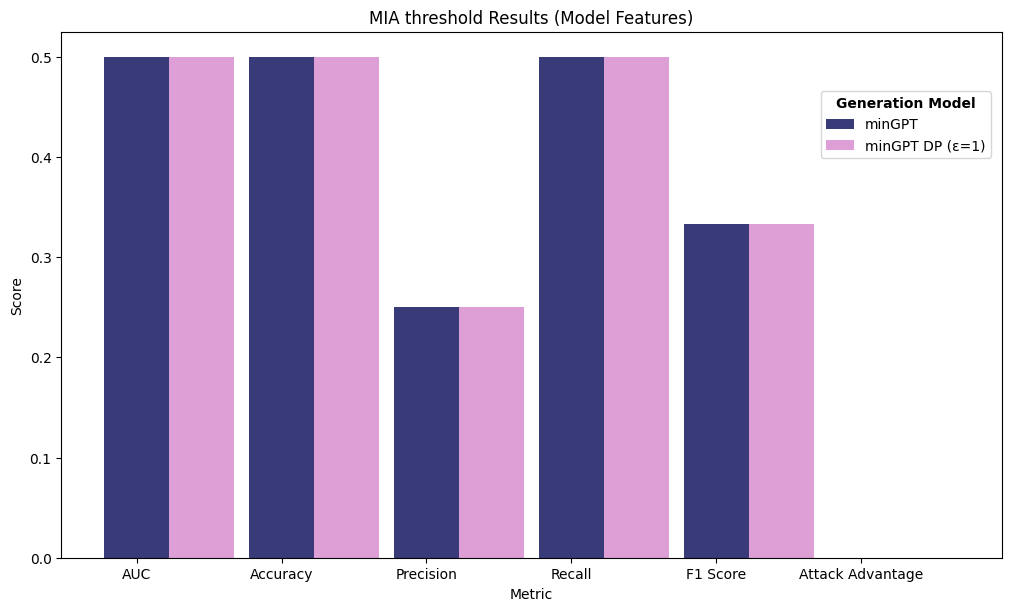

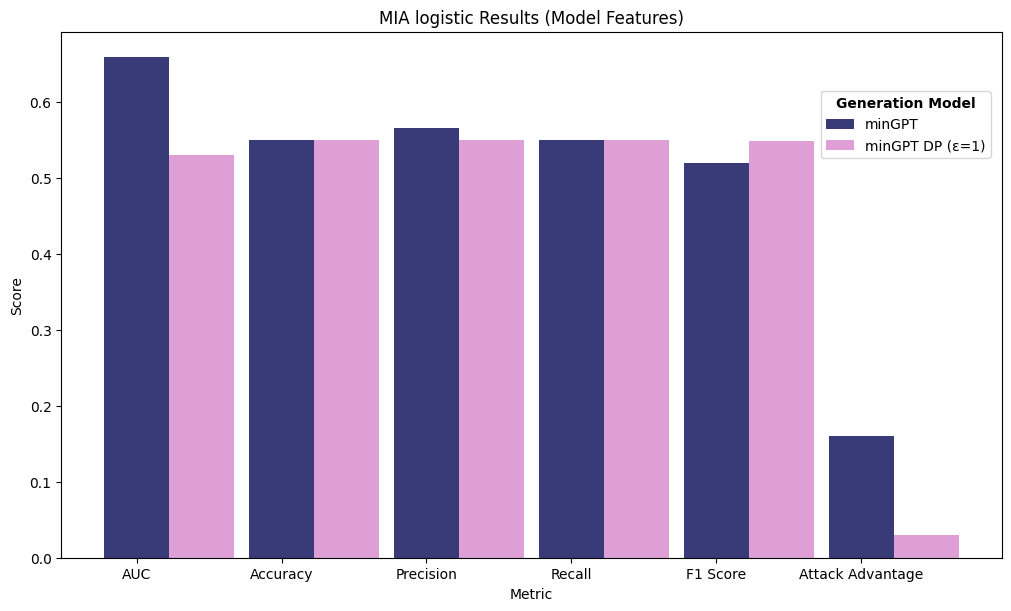

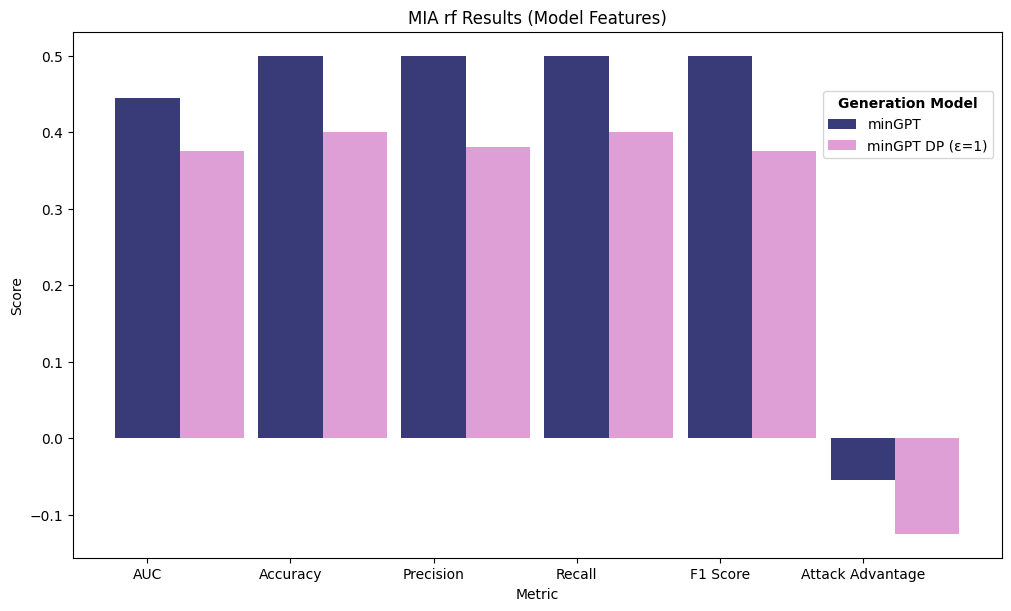

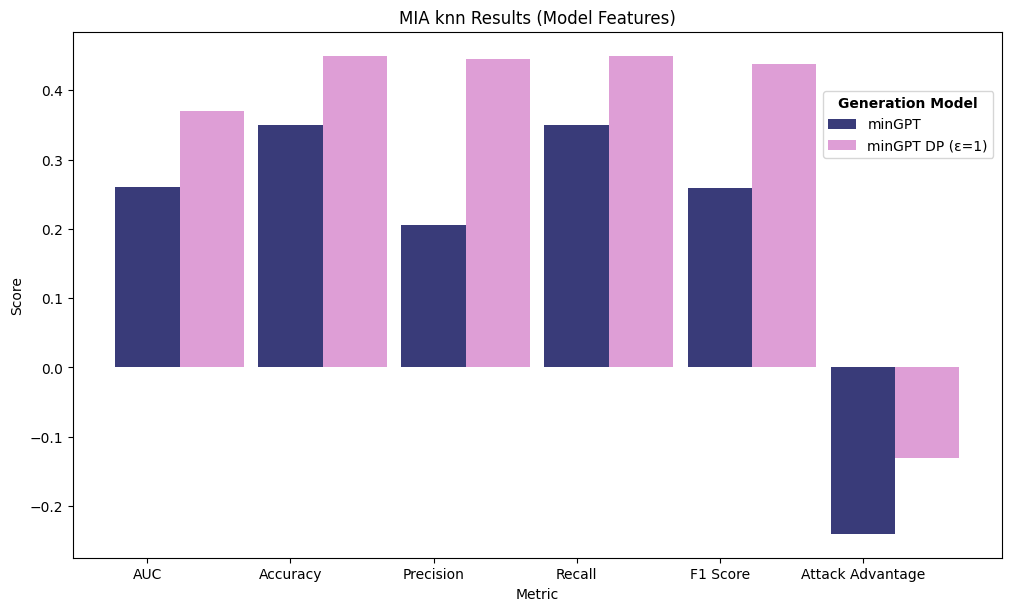

In [154]:
plot_mia_comparison(results, results_dp, eps=eps)

Extracting model-based features from 20 samples:   0%|          | 0/20 [00:00<?, ?it/s, Processing tokens (0 to 100)]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Extracting model-based features from 20 samples: 100%|██████████| 20/20 [00:40<00:00,  2.05s/it, Calculating Metrics]               


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 37.23it/s]



Attacks Results:
Risk Level: LOW-MODERATE
    Highest AUC: 0.5700
    Attack Advantage: 0.0700

- THRESHOLD: AUC=0.5000, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- LOGISTIC: AUC=0.5400, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.4949
- RF: AUC=0.5700, Accuracy=0.6000, Precision=0.6190, Recall=0.6000, F-Score=0.5833
- KNN: AUC=0.3700, Accuracy=0.3000, Precision=0.1875, Recall=0.3000, F-Score=0.2308



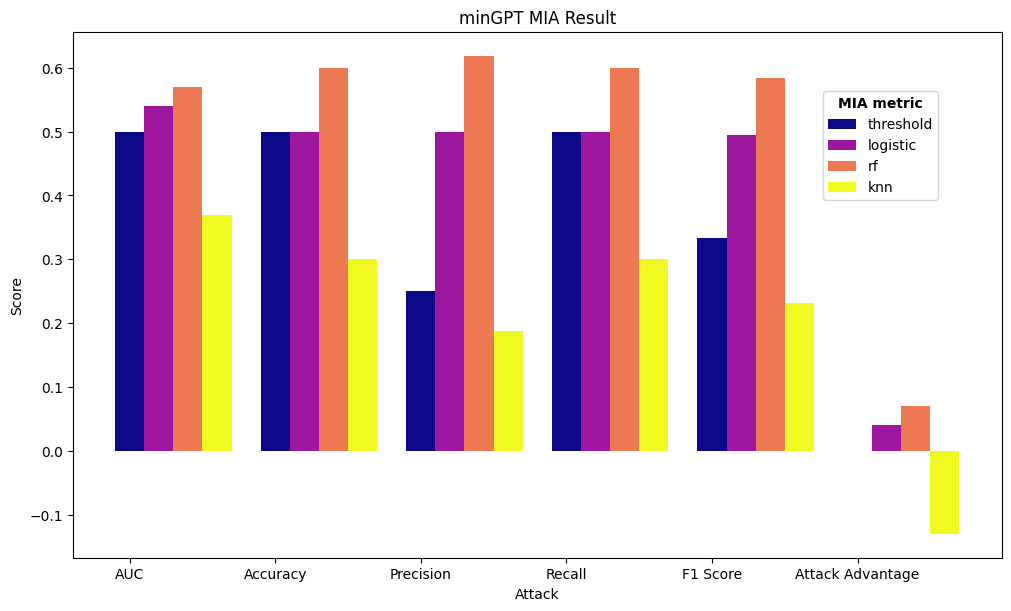

Extracting model-based features from 20 samples:   0%|          | 0/20 [00:00<?, ?it/s, Processing tokens (0 to 100)]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Extracting model-based features from 20 samples: 100%|██████████| 20/20 [00:41<00:00,  2.08s/it, Calculating Metrics]               


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 28.03it/s]



Attacks Results:
Risk Level: LOW
    Highest AUC: 0.5000
    Attack Advantage: 0.0000

- THRESHOLD: AUC=0.5000, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- LOGISTIC: AUC=0.5000, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.5000
- RF: AUC=0.4100, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.5000
- KNN: AUC=0.3650, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.4048



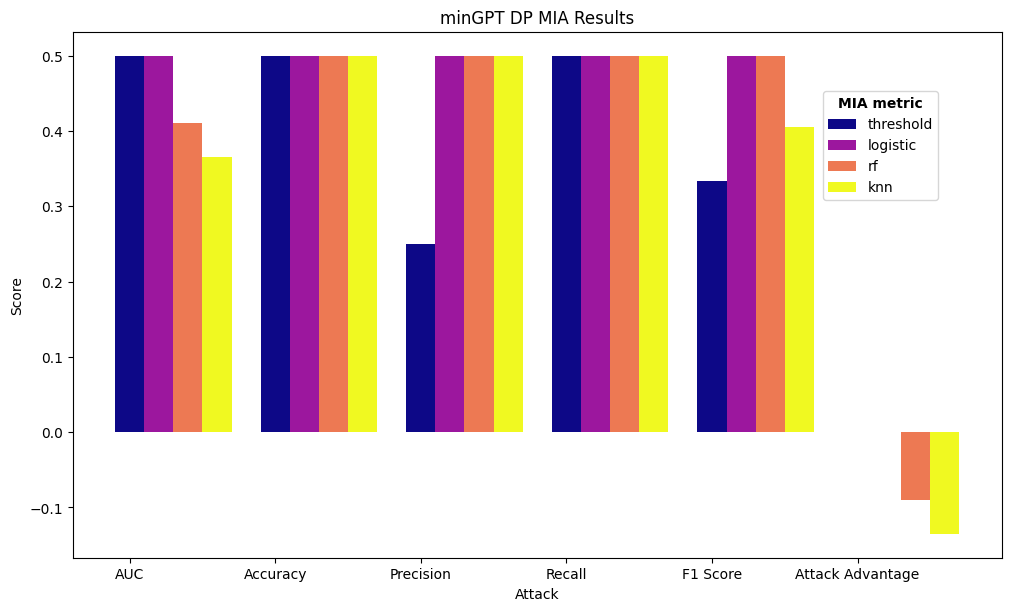

In [ ]:
results = run_blackbox_mia(mingpt, regex_tokenizer, train_seq, test_seq, 
                           include_genomic_features=False,
                           title="minGPT MIA Result")
results_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, 
                              include_genomic_features=False,
                              title="minGPT DP MIA Results")

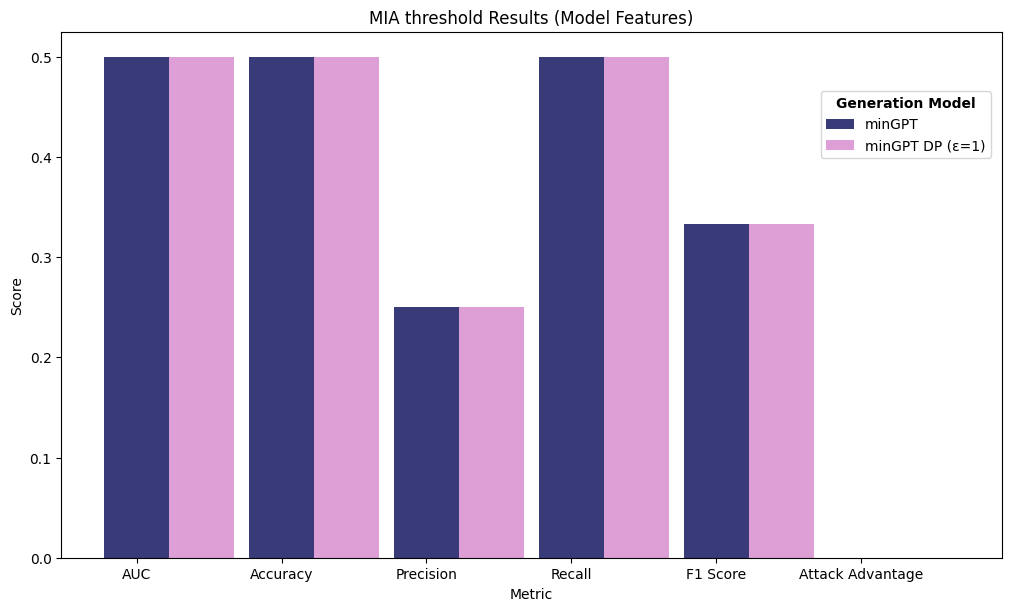

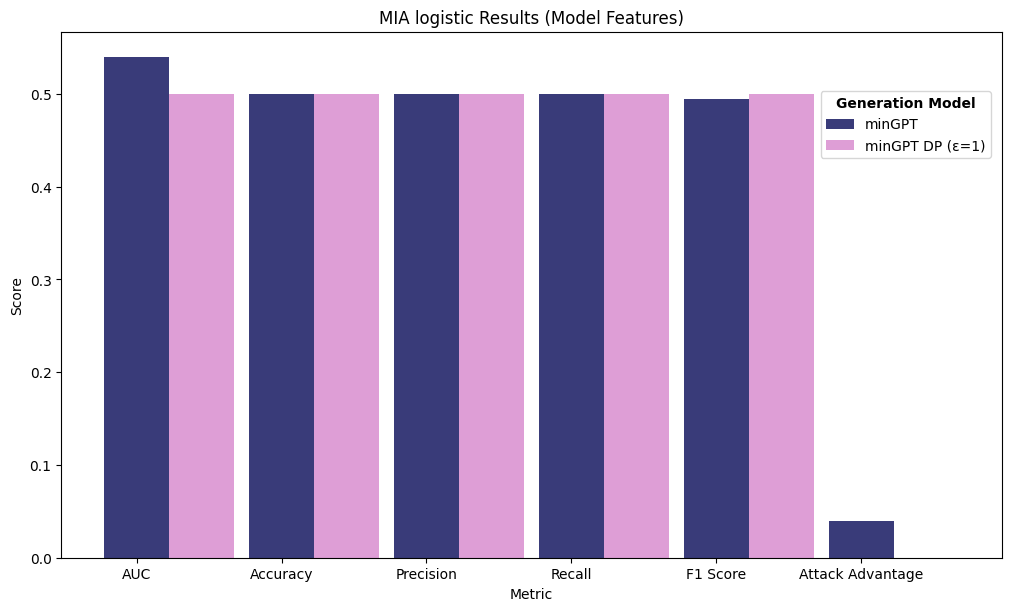

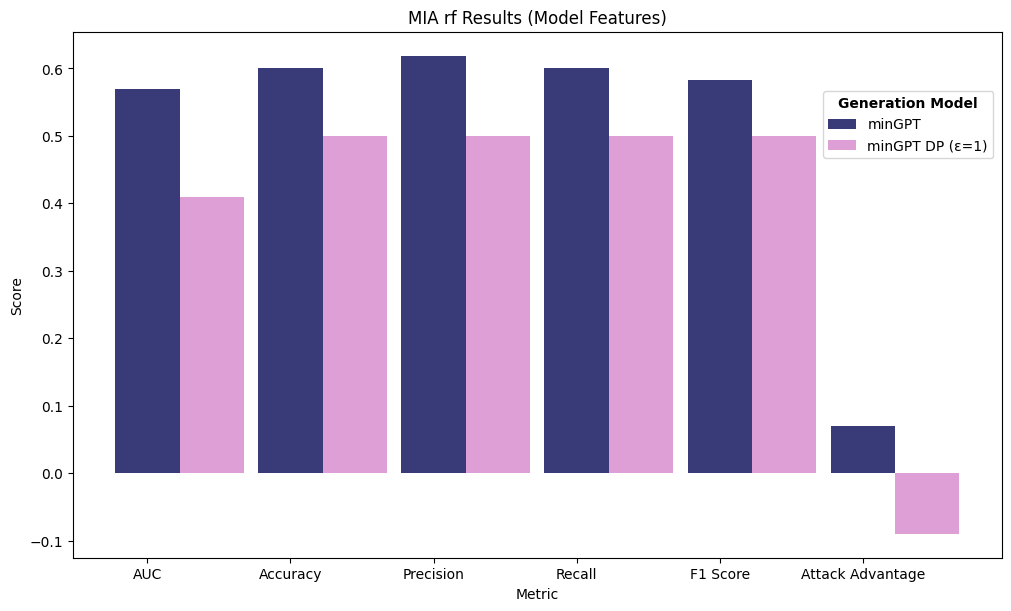

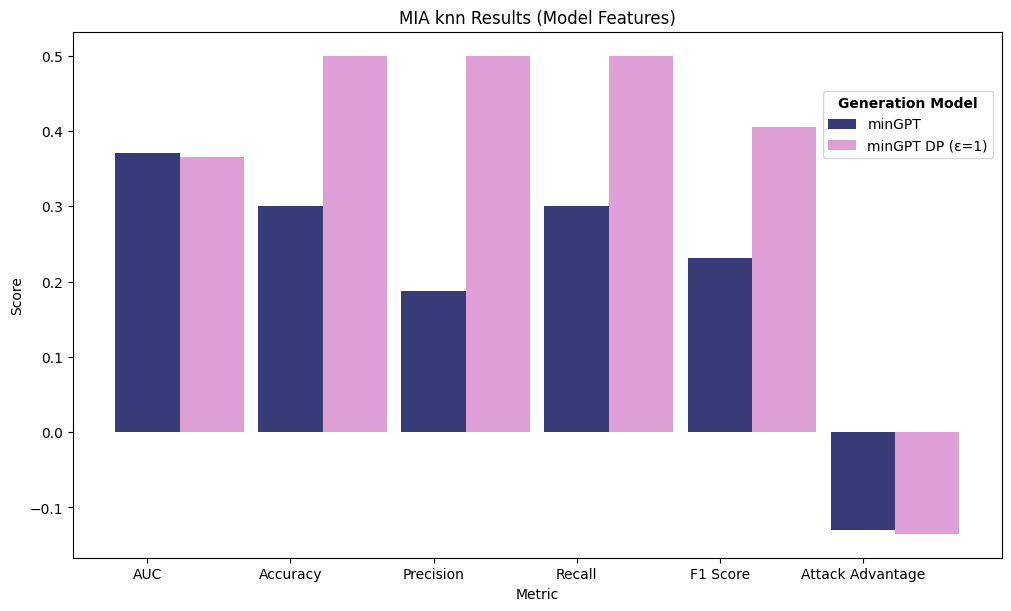

In [155]:
plot_mia_comparison(results_2, results_dp_2, eps=eps)

___

In [214]:
from importlib import reload

import attacks
reload(attacks)
from attacks import *

___
### 2.2 Hybrid Features

Extracting model-based features from 20 samples:   0%|          | 0/20 [00:00<?, ?it/s, Processing tokens (0 to 512)]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Extracting model-based features from 20 samples: 100%|██████████| 20/20 [00:01<00:00, 13.38it/s, Calculating Metrics]           


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 31.89it/s]


Attacks Results: Risk Level: HIGH (Max AUC=0.8175)
- THRESHOLD: AUC=0.8175, Accuracy=0.7750, Precision=0.7813, Recall=0.7750, F-Score=0.7737
- LOGISTIC: AUC=0.7100, Accuracy=0.7000, Precision=0.7083, Recall=0.7000, F-Score=0.6970
- RF: AUC=0.7550, Accuracy=0.7500, Precision=0.7747, Recall=0.7500, F-Score=0.7442
- KNN: AUC=0.6200, Accuracy=0.4500, Precision=0.2368, Recall=0.4500, F-Score=0.3103



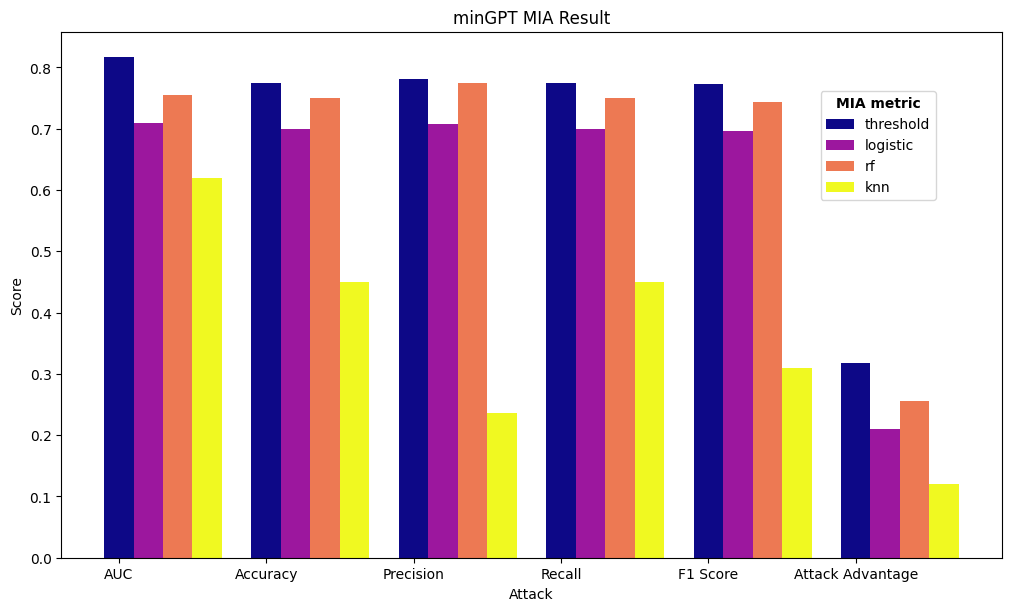

Extracting model-based features from 20 samples:   0%|          | 0/20 [00:00<?, ?it/s, Processing tokens (0 to 512)]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Extracting model-based features from 20 samples: 100%|██████████| 20/20 [00:01<00:00, 13.60it/s, Calculating Metrics]           


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 35.76it/s]


Attacks Results: Risk Level: LOW-MODERATE (Max AUC=0.5850)
- THRESHOLD: AUC=0.5850, Accuracy=0.6000, Precision=0.6190, Recall=0.6000, F-Score=0.5833
- LOGISTIC: AUC=0.5100, Accuracy=0.4500, Precision=0.4451, Recall=0.4500, F-Score=0.4373
- RF: AUC=0.4950, Accuracy=0.4000, Precision=0.4000, Recall=0.4000, F-Score=0.4000
- KNN: AUC=0.4500, Accuracy=0.5500, Precision=0.7632, Recall=0.5500, F-Score=0.4357



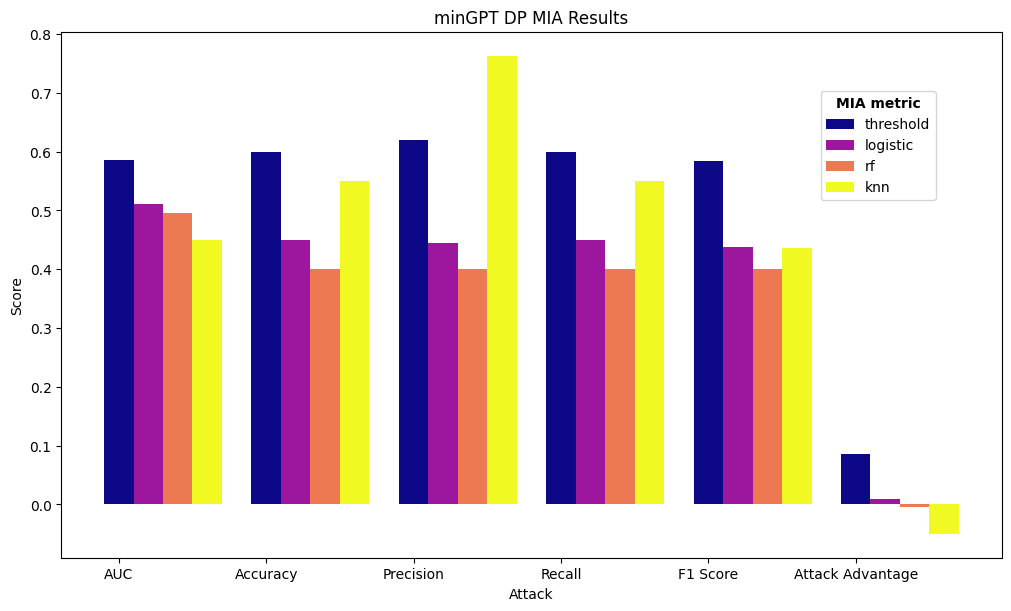

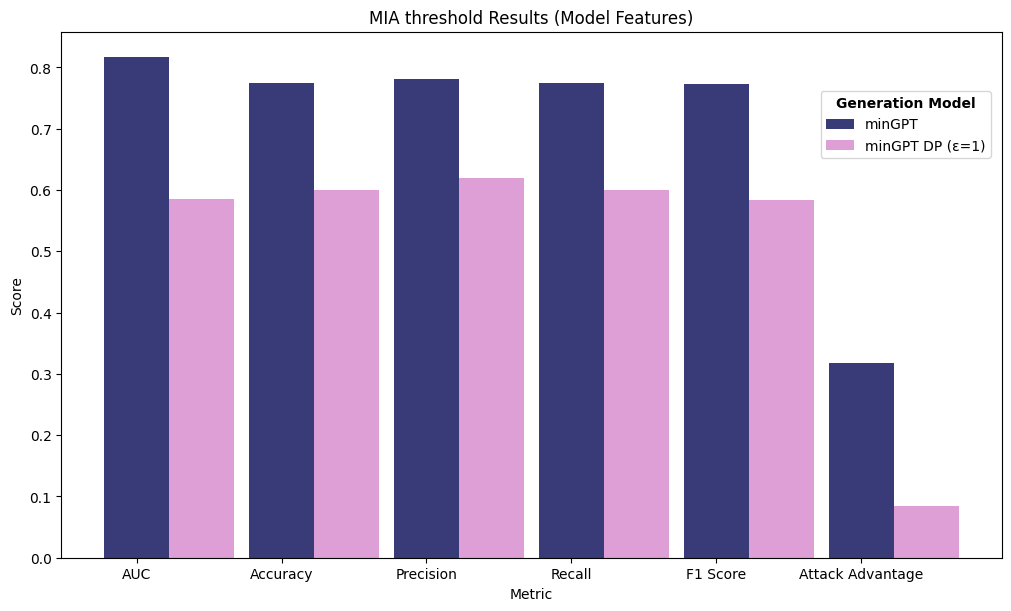

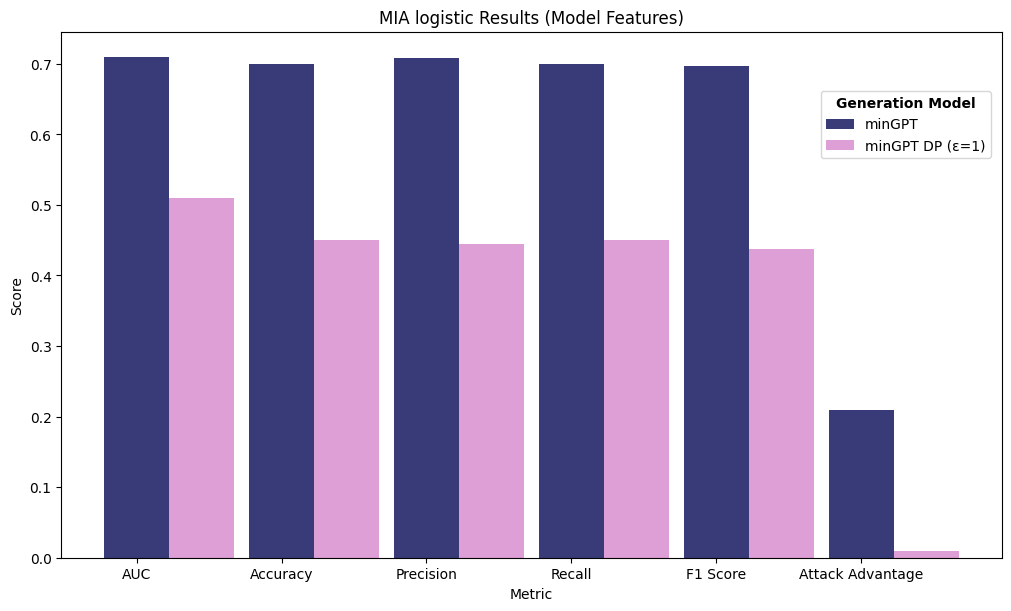

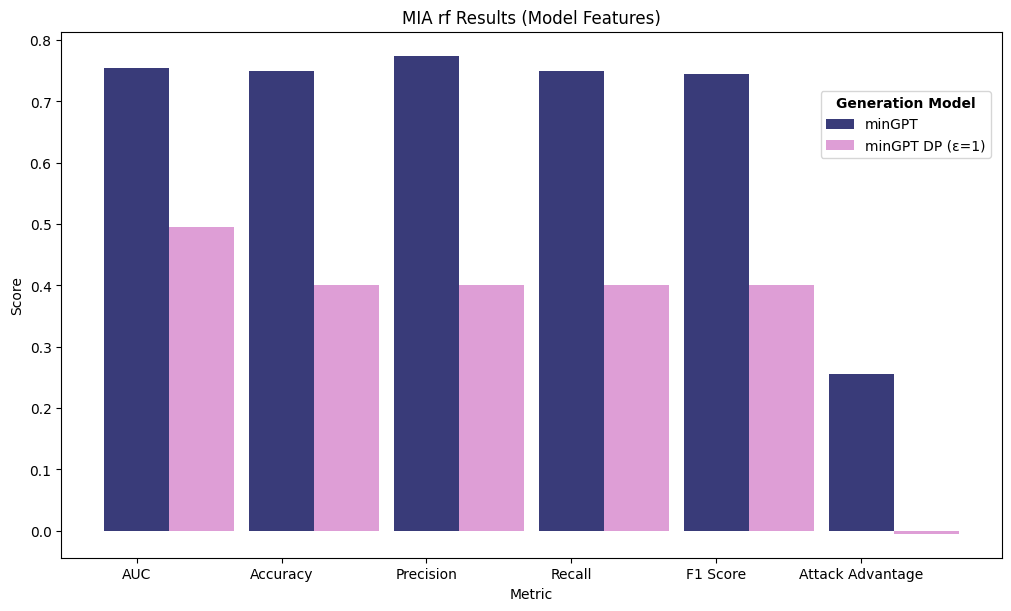

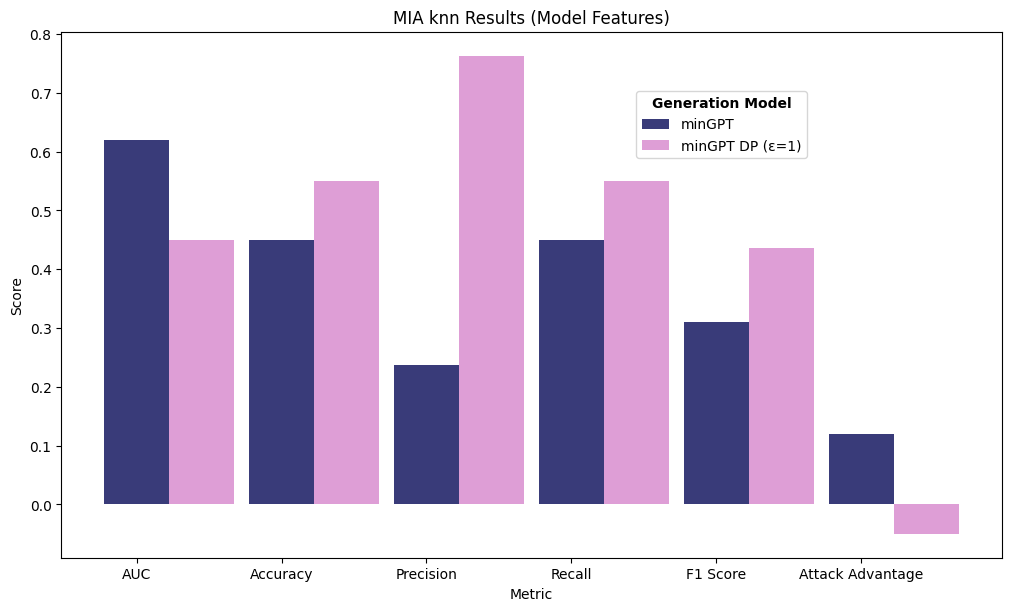

In [204]:
results_hybrid_model = run_blackbox_mia(mingpt, regex_tokenizer, train_seq, test_seq, 
                           include_genomic_features=False,
                           title="minGPT MIA Result")
results_hybrid_model_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, 
                              include_genomic_features=False,
                              title="minGPT DP MIA Results")
plot_mia_comparison(results_hybrid_model, results_hybrid_model_dp, eps=eps)

Extracting hybrid features from 20 samples:   0%|          | 0/20 [00:00<?, ?it/s, Processing tokens (0 to 512)]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Extracting hybrid features from 20 samples: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s, Getting Mutation Features from prompt 22:17352975:T>C_0|1 22:17363543:C>T_1|0]


Running threshold attack...


Running logistic attack...:   0%|          | 0/3 [00:00<?, ?it/s]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 20.34it/s]


Attacks Results: Risk Level: HIGH (Max AUC=0.8175)
- THRESHOLD: AUC=0.8175, Accuracy=0.7750, Precision=0.7813, Recall=0.7750, F-Score=0.7737
- LOGISTIC: AUC=0.4300, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.4792
- RF: AUC=0.7100, Accuracy=0.6500, Precision=0.6515, Recall=0.6500, F-Score=0.6491
- KNN: AUC=0.6200, Accuracy=0.4500, Precision=0.2368, Recall=0.4500, F-Score=0.3103



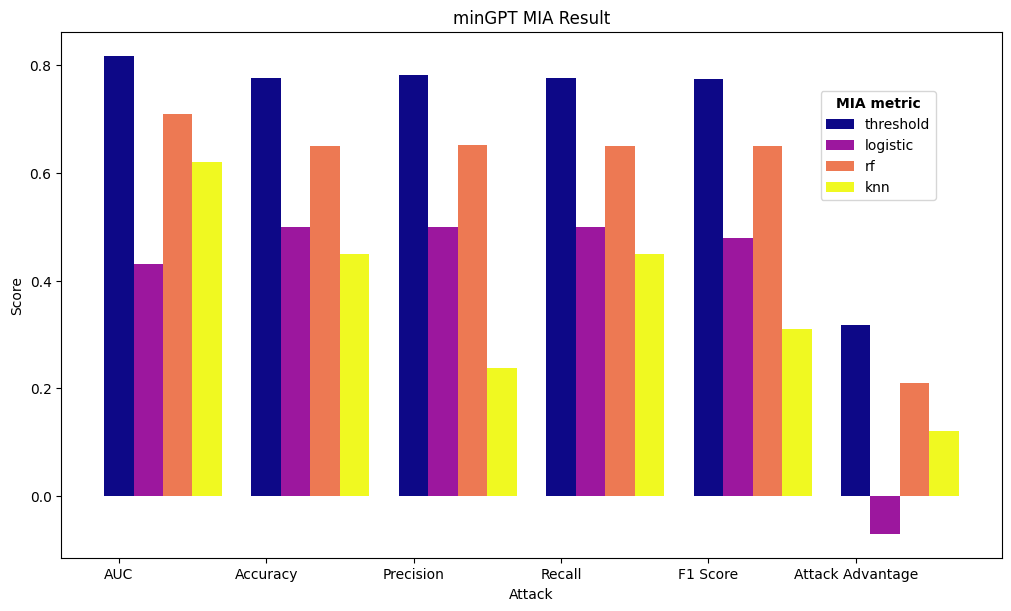

Extracting hybrid features from 20 samples:   0%|          | 0/20 [00:00<?, ?it/s, Processing tokens (0 to 512)]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Extracting hybrid features from 20 samples: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s, Getting Mutation Features from prompt 22:17352975:T>C_0|1 22:17363543:C>T_1|0]


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 27.12it/s]


Attacks Results: Risk Level: LOW-MODERATE (Max AUC=0.6000)
- THRESHOLD: AUC=0.5850, Accuracy=0.6000, Precision=0.6190, Recall=0.6000, F-Score=0.5833
- LOGISTIC: AUC=0.6000, Accuracy=0.6000, Precision=0.6042, Recall=0.6000, F-Score=0.5960
- RF: AUC=0.4550, Accuracy=0.4000, Precision=0.4000, Recall=0.4000, F-Score=0.4000
- KNN: AUC=0.3650, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.4048



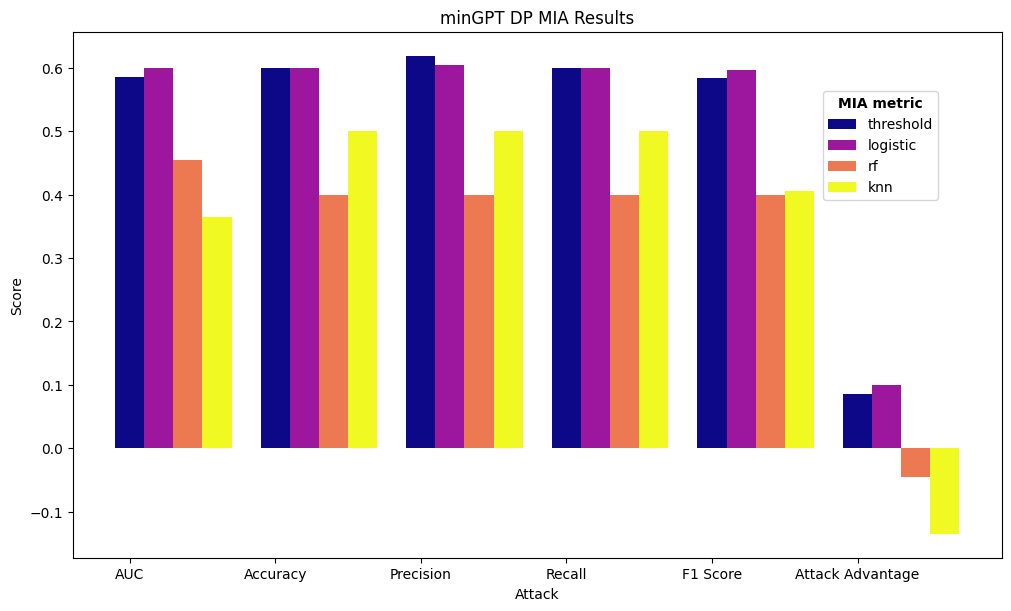

In [202]:
train_seq, test_seq = get_train_test_sequences(test_rare_only=False, 
                                               test_high_risk=True, 
                                               num_samples=20)

results_hybrid = run_blackbox_mia(mingpt, regex_tokenizer, train_seq, test_seq, 
                           include_genomic_features=True,
                           title="minGPT MIA Result")
results_hybrid_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, 
                              include_genomic_features=True,
                              title="minGPT DP MIA Results")

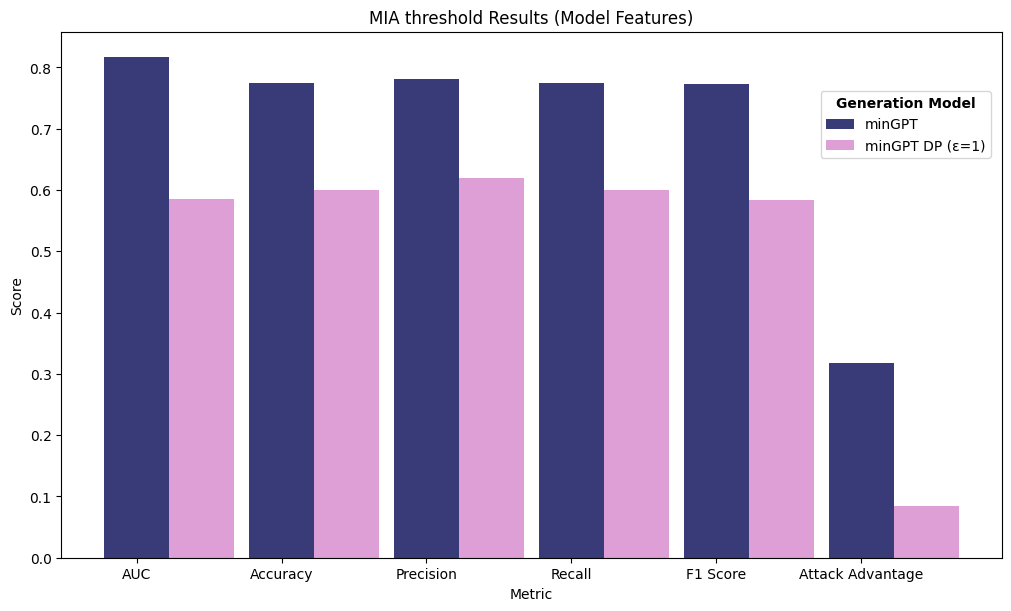

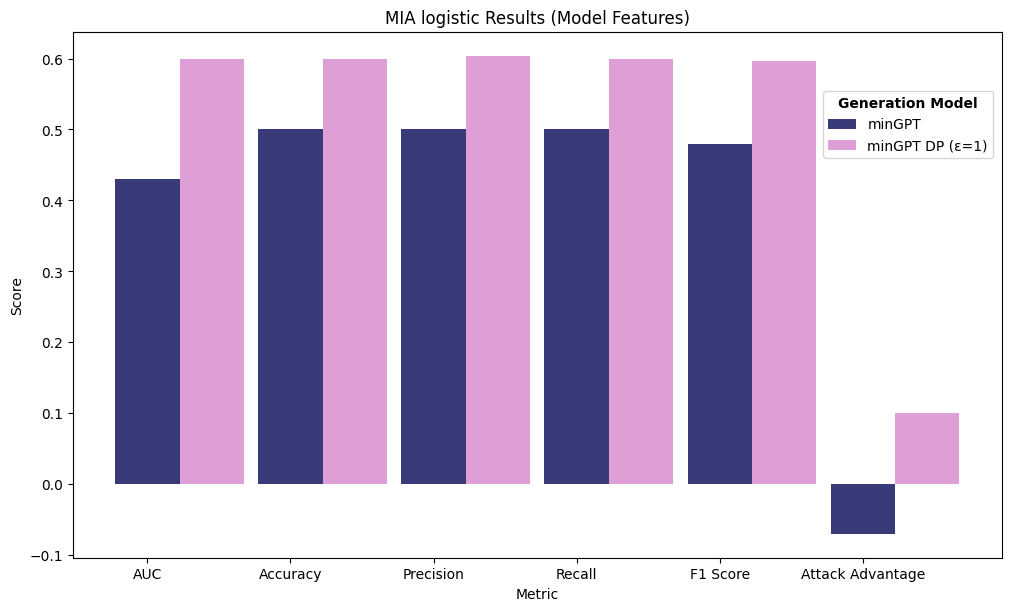

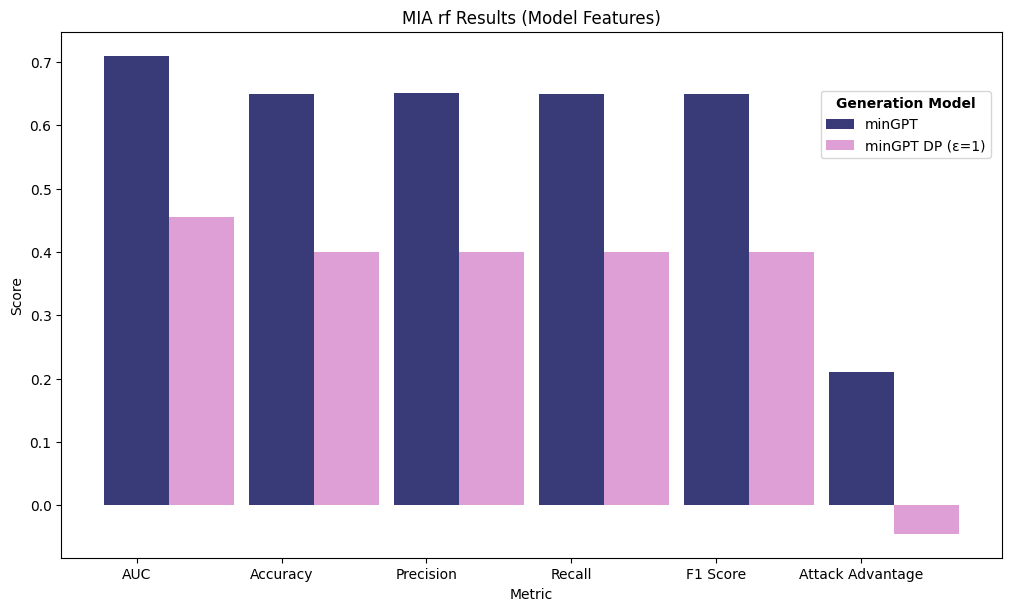

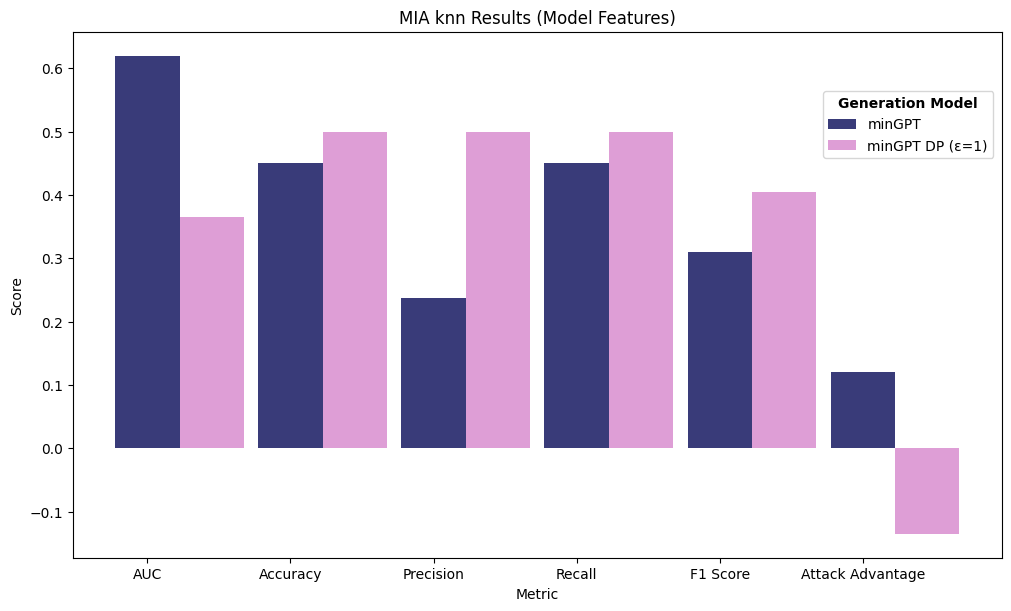

In [203]:
plot_mia_comparison(results_hybrid, results_hybrid_dp, eps=eps)

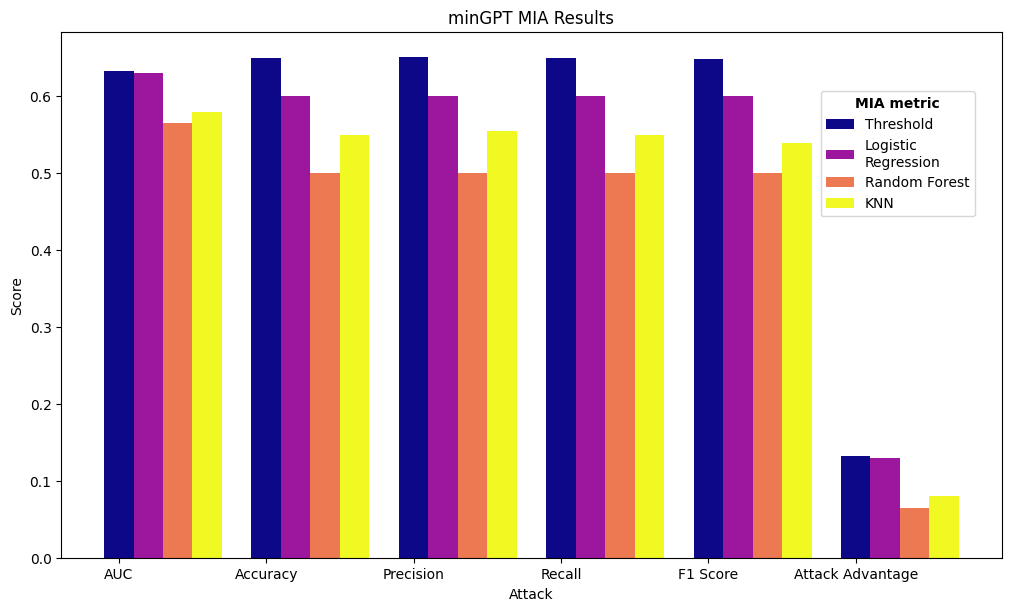

In [ ]:
train_seq, test_seq = get_train_test_sequences(test_rare_only=False, test_high_risk=True, num_samples=20)
results_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq)

results_to_plot = [[
    mia_results['auc'],
    mia_results['accuracy'],
    mia_results['precision'],
    mia_results['recall'],
    mia_results['fscore'],
    mia_results['attack_advantage']
] for mia_results in results_dp.values()]
plot_metrics_by_model(results_to_plot, model_names=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'], 
                                        labels = ['Threshold', 'Logistic\nRegression',
                                                    'Random Forest', 'KNN'],
                                        legend_title='MIA metric',
                                        x_ticks=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'],
                                        xlabel = 'Attack', ylabel='Score',
                                        title="minGPT DP (ε=1) MIA Results", 
                                        save_path=None,
                                        bbox_to_anchor=(0.8, 0.9))

___
## Comparison between non-DP and DP Model

Extracting model-based features from 27 samples: 100%|██████████| 27/27 [00:01<00:00, 14.19it/s, Calculating Metrics]         


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00,  9.45it/s]     


Attacks Results: Risk Level: LOW-MODERATE (Max AUC=0.5657)
- THRESHOLD: AUC=0.5507, Accuracy=0.7874, Precision=0.3937, Recall=0.5000, F-Score=0.4405
- LOGISTIC: AUC=0.5529, Accuracy=0.7812, Precision=0.6452, Recall=0.5257, F-Score=0.5000
- RF: AUC=0.5657, Accuracy=0.7344, Precision=0.4898, Recall=0.4957, F-Score=0.4746
- KNN: AUC=0.5343, Accuracy=0.6875, Precision=0.4889, Recall=0.4914, F-Score=0.4872



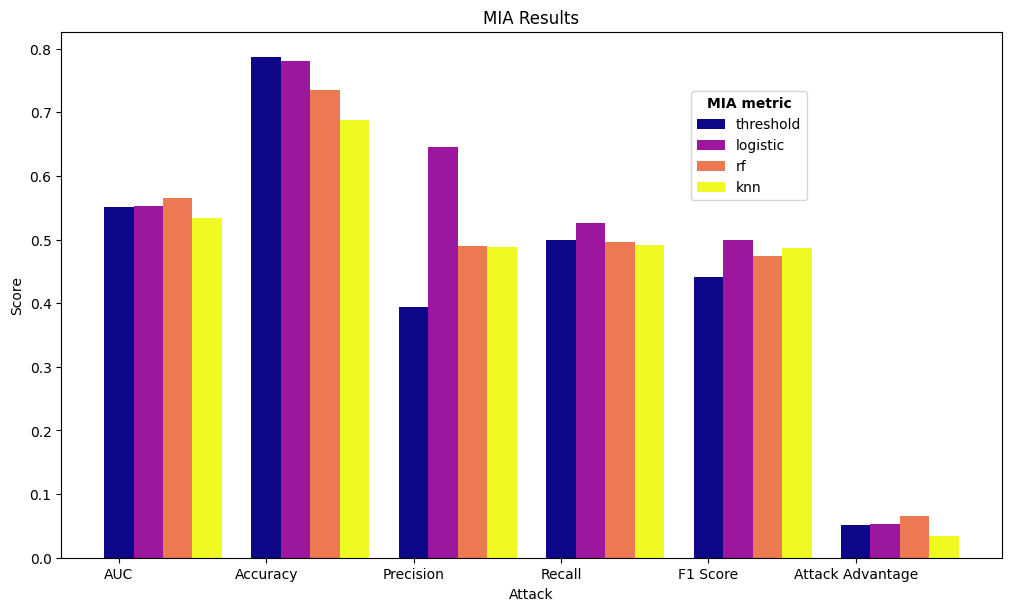

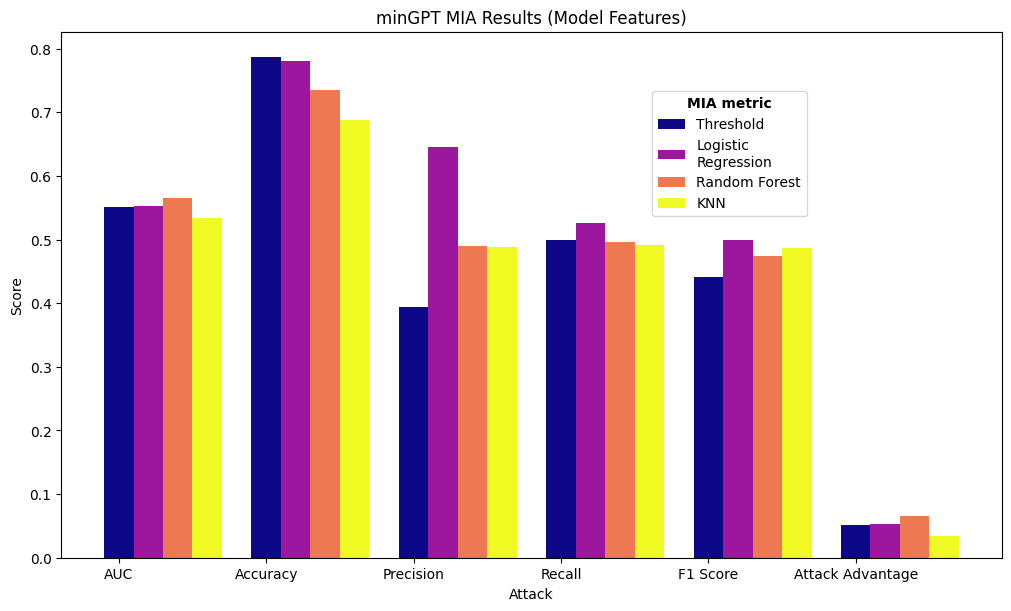

In [ ]:
train_seq, test_seq = get_train_test_sequences(test_rare_only=False, test_high_risk=True, num_samples=100)
results = run_blackbox_mia(mingpt, regex_tokenizer, train_seq, test_seq, include_genomic_features=False)

results_to_plot_nodp = [[
    mia_results['auc'],
    mia_results['accuracy'],
    mia_results['precision'],
    mia_results['recall'],
    mia_results['fscore'],
    mia_results['attack_advantage']
] for mia_results in results.values()]
plot_metrics_by_model(results_to_plot_nodp, model_names=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'], 
                                        labels = ['Threshold', 'Logistic\nRegression',
                                                    'Random Forest', 'KNN'],
                                        legend_title='MIA metric',
                                        x_ticks=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'],
                                        xlabel = 'Attack', ylabel='Score',
                                        title="minGPT MIA Results (High-Risk Model Based)", 
                                        save_path=f'figures/generated_data/privacy_eval/minGPT_MIA_High_Risk.pdf',
                                        cmap='plasma',
                                        bbox_to_anchor=(0.8, 0.9))

Extracting model-based features from 27 samples: 100%|██████████| 27/27 [00:01<00:00, 14.72it/s, Calculating Metrics]         


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 15.00it/s]


Attacks Results: Risk Level: LOW (Max AUC=0.5415)
- THRESHOLD: AUC=0.5415, Accuracy=0.7874, Precision=0.3937, Recall=0.5000, F-Score=0.4405
- LOGISTIC: AUC=0.4557, Accuracy=0.7812, Precision=0.3906, Recall=0.5000, F-Score=0.4386
- RF: AUC=0.3021, Accuracy=0.7031, Precision=0.4574, Recall=0.4757, F-Score=0.4588
- KNN: AUC=0.4600, Accuracy=0.7500, Precision=0.3871, Recall=0.4800, F-Score=0.4286



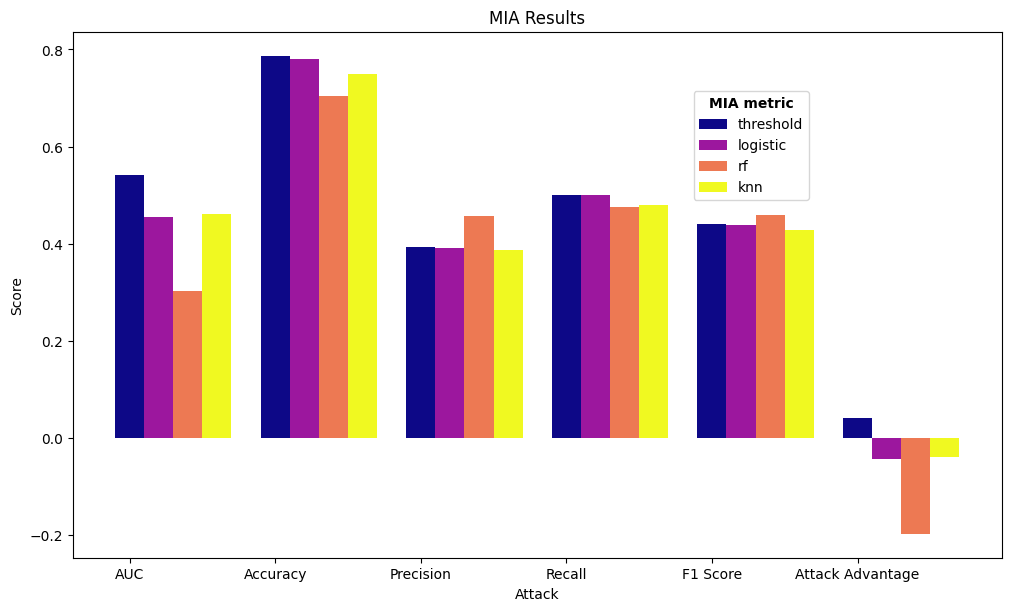

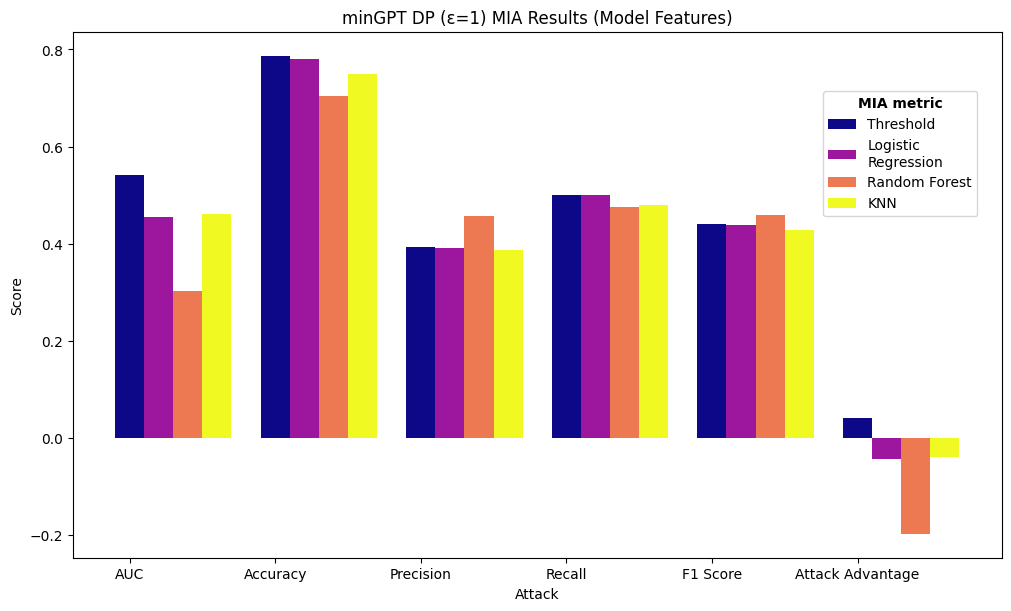

In [ ]:
# train_seq, test_seq = get_train_test_sequences(test_rare_only=False, test_high_risk=True, num_samples=100)
results_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, include_genomic_features=False)

results_to_plot_dp = [[
    mia_results['auc'],
    mia_results['accuracy'],
    mia_results['precision'],
    mia_results['recall'],
    mia_results['fscore'],
    mia_results['attack_advantage']
] for mia_results in results_dp.values()]
plot_metrics_by_model(results_to_plot_dp, model_names=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'], 
                                        labels = ['Threshold', 'Logistic\nRegression',
                                                    'Random Forest', 'KNN'],
                                        legend_title='MIA metric',
                                        x_ticks=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'],
                                        xlabel = 'Attack', ylabel='Score',
                                        title="minGPT (DP) MIA Results (High-Risk Model Based)", 
                                        save_path=f'figures/generated_data/privacy_eval/minGPT_DP_MIA_High_Risk.pdf',
                                        cmap='plasma',
                                        bbox_to_anchor=(0.8, 0.9))

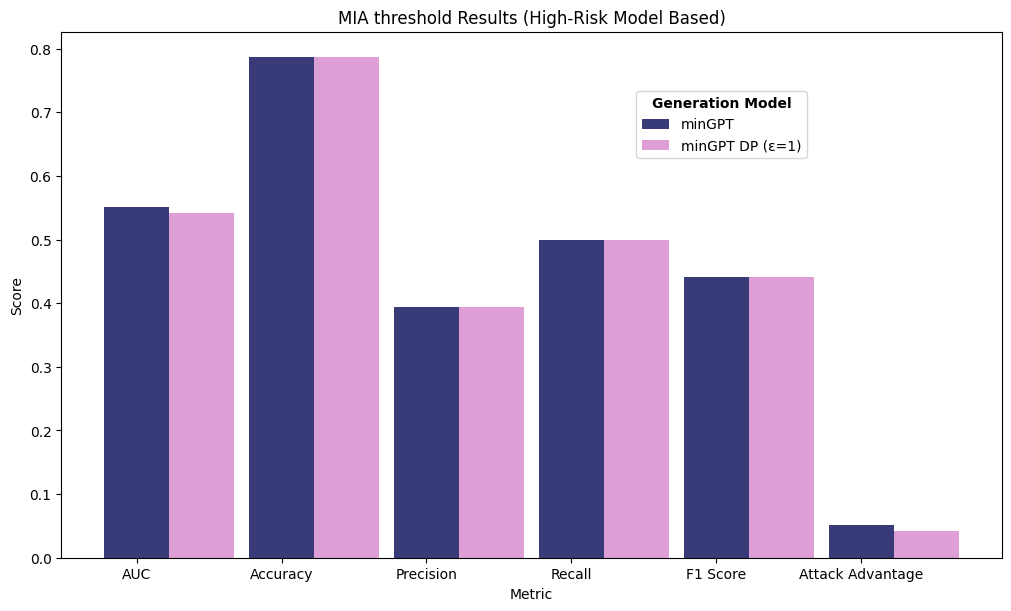

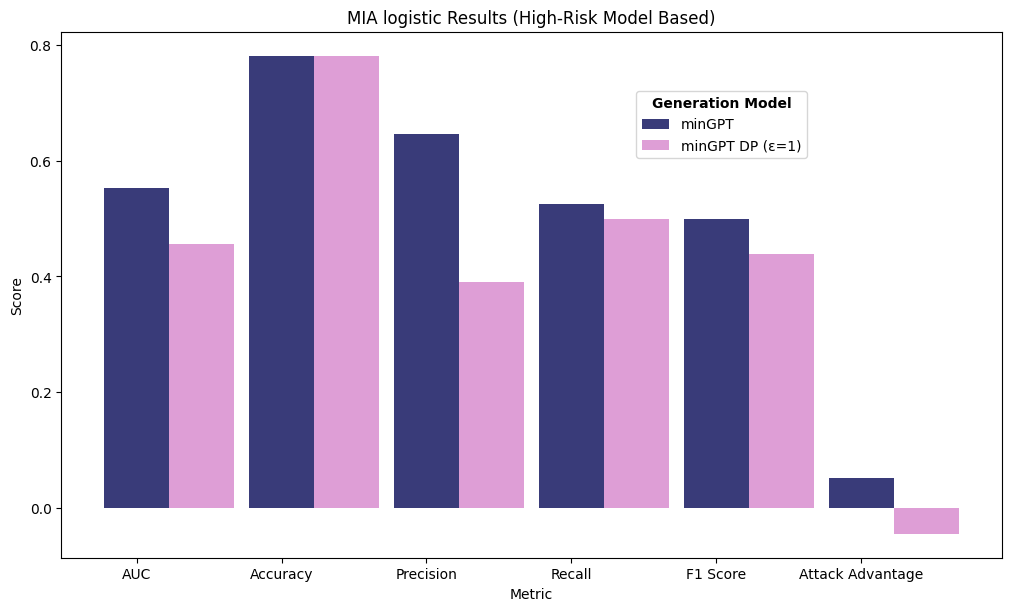

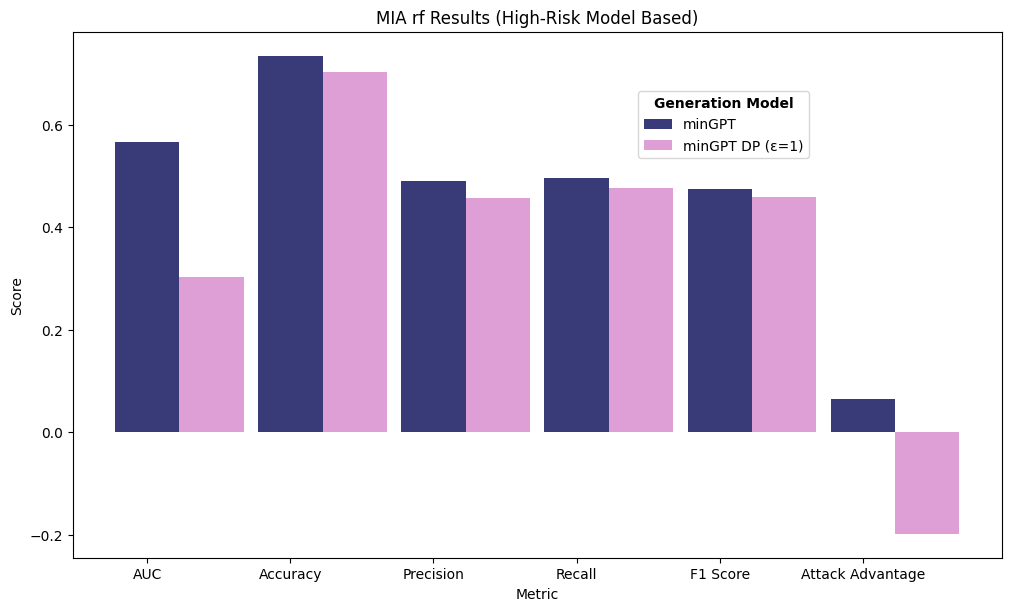

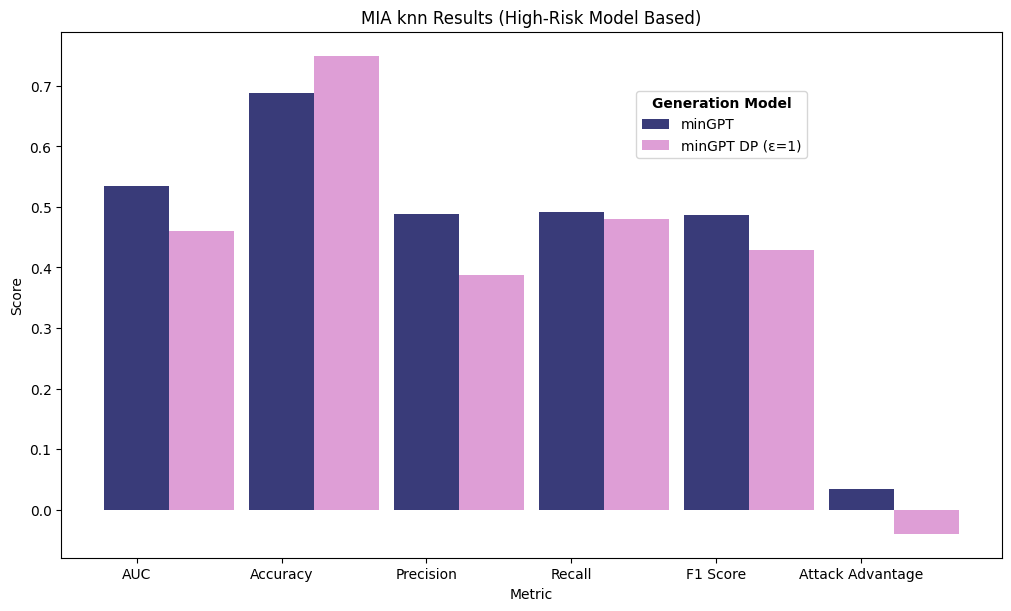

In [167]:
for ((res_k, res), (dp_res_k, dp_res)) in zip(results.items(), results_dp.items()):
    results_to_plot = [[
        res['auc'],
        res['accuracy'],
        res['precision'],
        res['recall'],
        res['fscore'],
        res['attack_advantage']],
        [dp_res['auc'],
        dp_res['accuracy'],
        dp_res['precision'],
        dp_res['recall'],
        dp_res['fscore'],
        dp_res['attack_advantage']]]
    plot_metrics_by_model(results_to_plot, model_names=['AUC', 'Accuracy', 'Precision', 
                                                    'Recall', 'F1 Score', 'Attack Advantage'], 
                                            labels = ['minGPT', 'minGPT DP (ε=1)'],
                                            x_ticks=['AUC', 'Accuracy', 'Precision', 
                                                    'Recall', 'F1 Score', 'Attack Advantage'],
                                            xlabel = 'Metric', ylabel='Score',
                                            title=f'MIA {res_k} Results (High-Risk Model Based)', 
                                            cmap='tab20b',
                                            save_path=f'figures/generated_data/privacy_eval/MIA_{res_k}_high_risk.pdf',
                                            bbox_to_anchor=(0.8, 0.9))

Extracting hybrid features from 27 samples: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s, Getting Mutation Features from prompt 22:16579113:C>T_1|1 22:17219096:A>T_0|1]


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 17.82it/s]


Attacks Results: Risk Level: LOW-MODERATE (Max AUC=0.5507)
- THRESHOLD: AUC=0.5507, Accuracy=0.7874, Precision=0.3937, Recall=0.5000, F-Score=0.4405
- LOGISTIC: AUC=0.5314, Accuracy=0.7969, Precision=0.7350, Recall=0.5614, F-Score=0.5591
- RF: AUC=0.4364, Accuracy=0.7656, Precision=0.3889, Recall=0.4900, F-Score=0.4336
- KNN: AUC=0.5343, Accuracy=0.6875, Precision=0.4889, Recall=0.4914, F-Score=0.4872



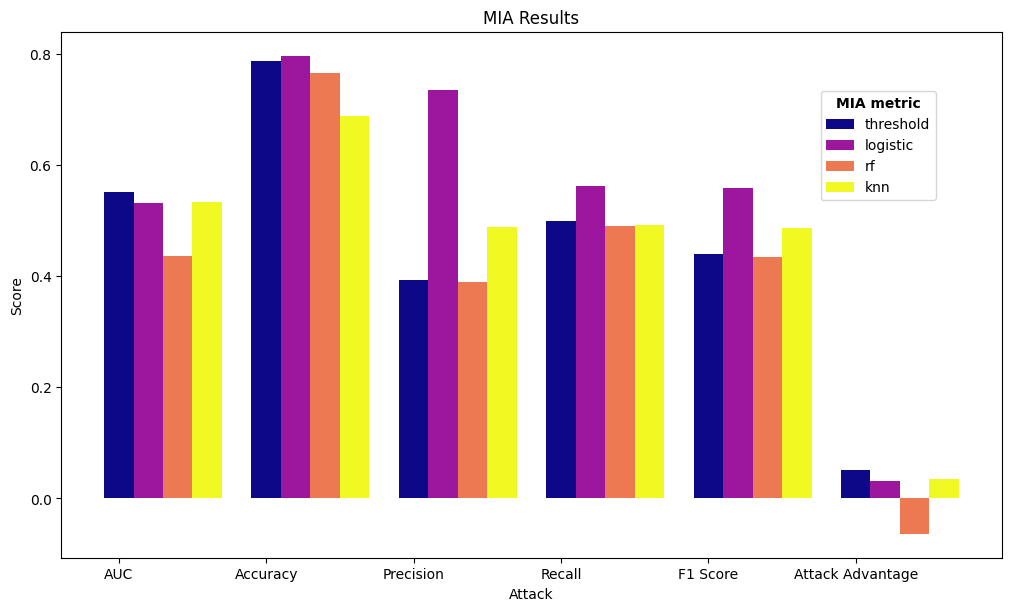

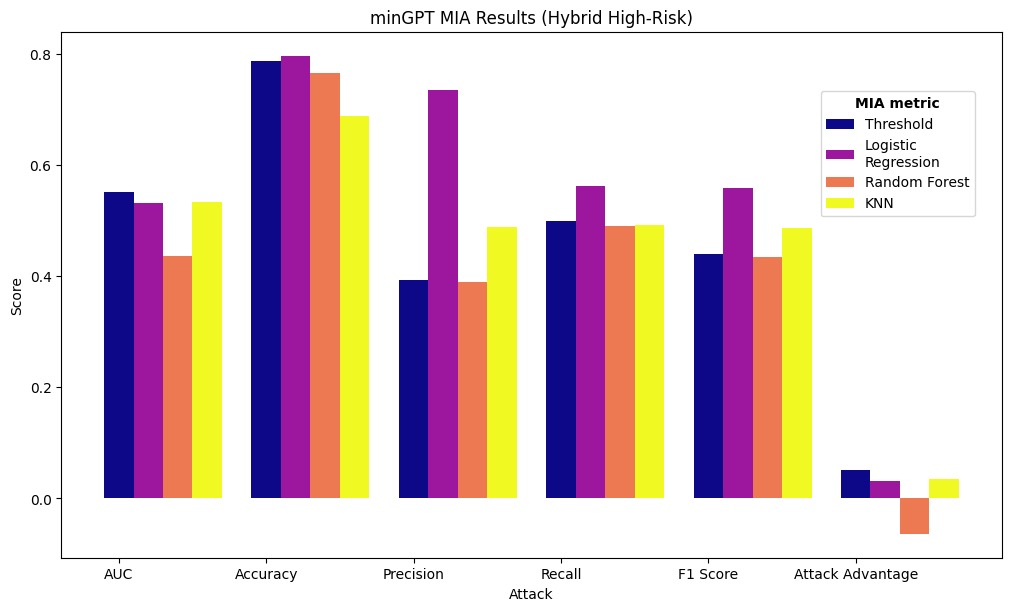

In [170]:
results = run_blackbox_mia(mingpt, regex_tokenizer, train_seq, test_seq, include_genomic_features=True)

results_to_plot_nodp = [[
    mia_results['auc'],
    mia_results['accuracy'],
    mia_results['precision'],
    mia_results['recall'],
    mia_results['fscore'],
    mia_results['attack_advantage']
] for mia_results in results.values()]
plot_metrics_by_model(results_to_plot_nodp, model_names=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'], 
                                        labels = ['Threshold', 'Logistic\nRegression',
                                                    'Random Forest', 'KNN'],
                                        legend_title='MIA metric',
                                        x_ticks=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'],
                                        xlabel = 'Attack', ylabel='Score',
                                        title="minGPT MIA Results (Hybrid High-Risk)", 
                                        save_path=f'figures/generated_data/privacy_eval/minGPT_MIA_hybrid_High_Risk.pdf',
                                        cmap='plasma',
                                        bbox_to_anchor=(0.8, 0.9))

Extracting hybrid features from 27 samples: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s, Getting Mutation Features from prompt 22:16579113:C>T_1|1 22:17219096:A>T_0|1]


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 20.12it/s]


Attacks Results: Risk Level: LOW (Max AUC=0.5415)
- THRESHOLD: AUC=0.5415, Accuracy=0.7874, Precision=0.3937, Recall=0.5000, F-Score=0.4405
- LOGISTIC: AUC=0.3457, Accuracy=0.7656, Precision=0.3889, Recall=0.4900, F-Score=0.4336
- RF: AUC=0.3664, Accuracy=0.7812, Precision=0.3906, Recall=0.5000, F-Score=0.4386
- KNN: AUC=0.5386, Accuracy=0.7344, Precision=0.3852, Recall=0.4700, F-Score=0.4234



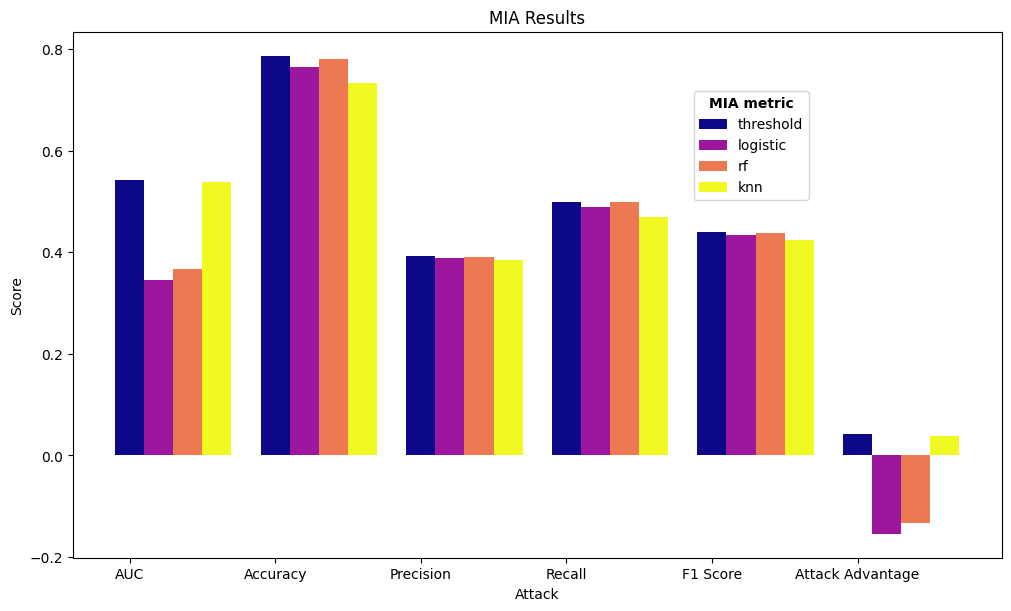

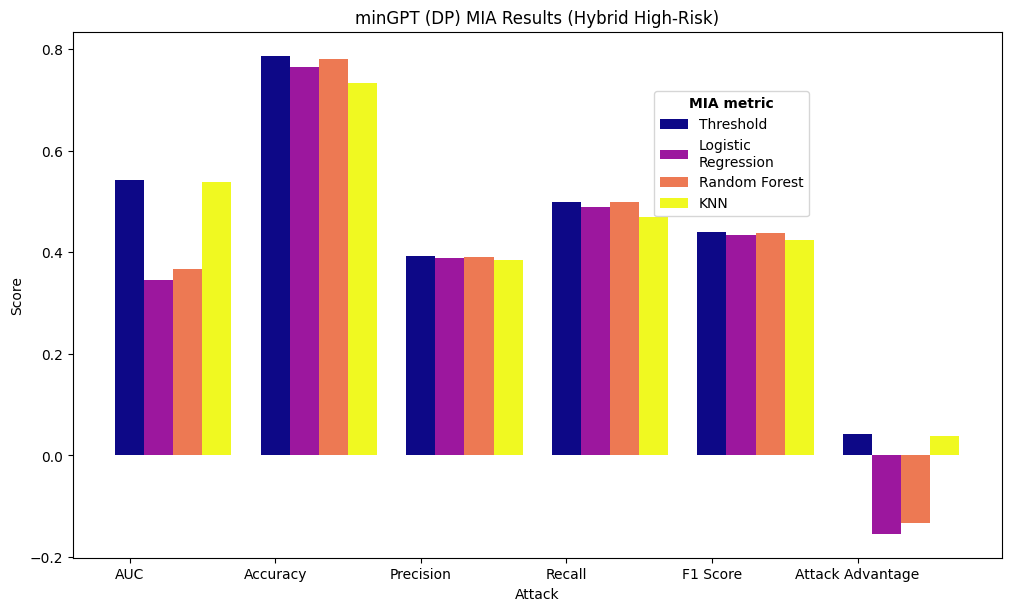

In [171]:
# train_seq, test_seq = get_train_test_sequences(test_rare_only=False, test_high_risk=True, num_samples=100)
results_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, include_genomic_features=True)

results_to_plot_dp = [[
    mia_results['auc'],
    mia_results['accuracy'],
    mia_results['precision'],
    mia_results['recall'],
    mia_results['fscore'],
    mia_results['attack_advantage']
] for mia_results in results_dp.values()]
plot_metrics_by_model(results_to_plot_dp, model_names=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'], 
                                        labels = ['Threshold', 'Logistic\nRegression',
                                                    'Random Forest', 'KNN'],
                                        legend_title='MIA metric',
                                        x_ticks=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'],
                                        xlabel = 'Attack', ylabel='Score',
                                        title="minGPT (DP) MIA Results (Hybrid High-Risk)", 
                                        save_path=f'figures/generated_data/privacy_eval/minGPT_DP_MIA_hybrid_High_Risk.pdf',
                                        cmap='plasma',
                                        bbox_to_anchor=(0.8, 0.9))

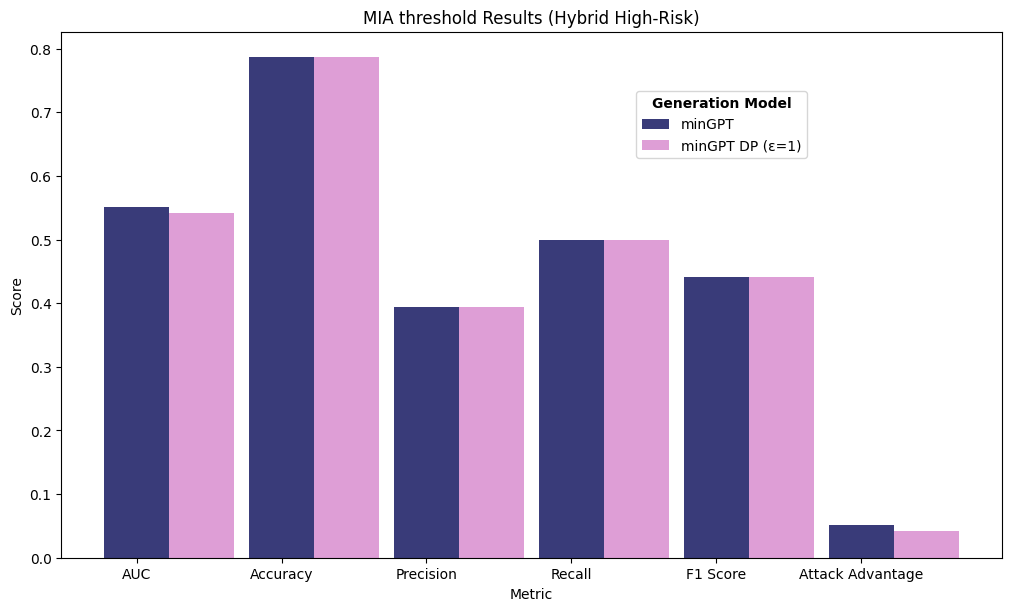

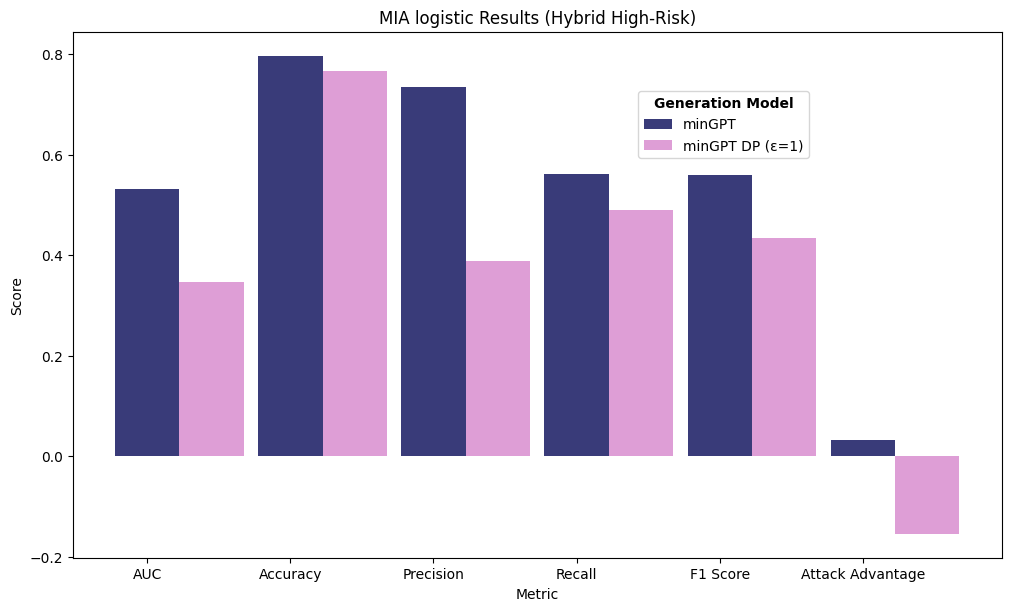

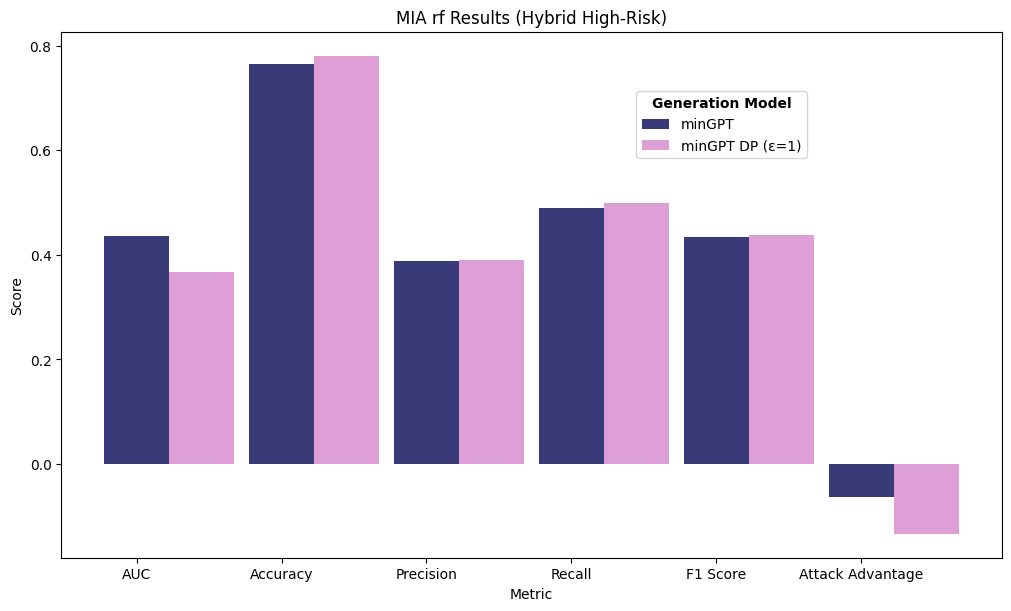

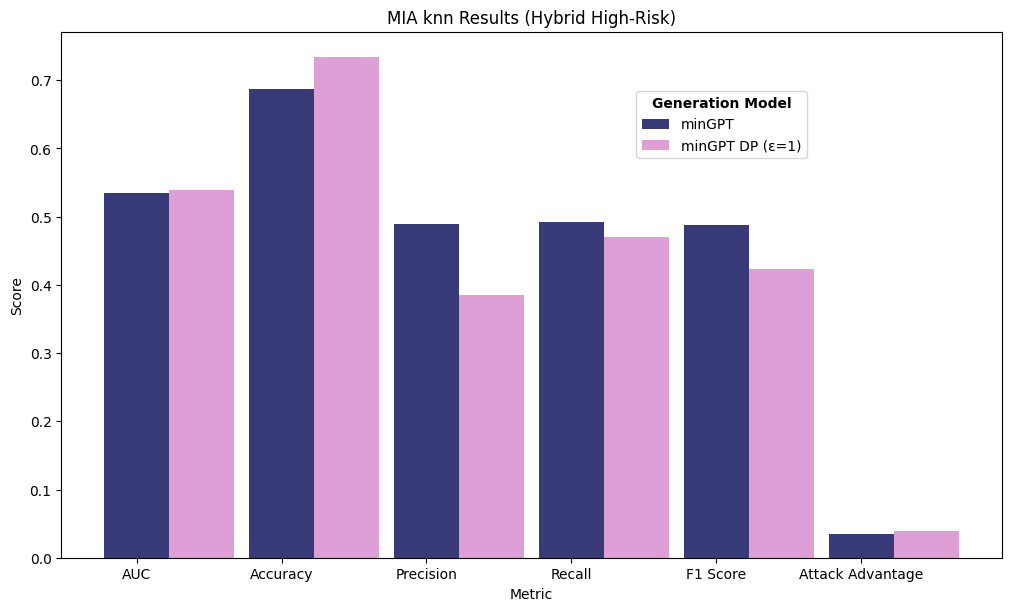

In [172]:
for ((res_k, res), (dp_res_k, dp_res)) in zip(results.items(), results_dp.items()):
    results_to_plot = [[
        res['auc'],
        res['accuracy'],
        res['precision'],
        res['recall'],
        res['fscore'],
        res['attack_advantage']],
        [dp_res['auc'],
        dp_res['accuracy'],
        dp_res['precision'],
        dp_res['recall'],
        dp_res['fscore'],
        dp_res['attack_advantage']]]
    plot_metrics_by_model(results_to_plot, model_names=['AUC', 'Accuracy', 'Precision', 
                                                    'Recall', 'F1 Score', 'Attack Advantage'], 
                                            labels = ['minGPT', 'minGPT DP (ε=1)'],
                                            x_ticks=['AUC', 'Accuracy', 'Precision', 
                                                    'Recall', 'F1 Score', 'Attack Advantage'],
                                            xlabel = 'Metric', ylabel='Score',
                                            title=f'MIA {res_k} Results (Hybrid High-Risk)', 
                                            cmap='tab20b',
                                            save_path=f'figures/generated_data/privacy_eval/MIA_{res_k}_hybrid_High_Risk.pdf',
                                            bbox_to_anchor=(0.8, 0.9))

___

In [30]:
train_seq, test_seq = get_train_test_sequences(test_rare_only=True, num_samples=50)
results = run_blackbox_mia(mingpt, regex_tokenizer, train_seq, test_seq, include_genomic_features=False)

Extracting features from 50 samples: 100%|██████████| 50/50 [01:15<00:00,  1.50s/it, Getting Average Logit Magnitude]
/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Running threshold attack...


Running logistic attack...:   0%|          | 0/3 [00:00<?, ?it/s]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running rf attack...:   0%|          | 0/3 [00:00<?, ?it/s]      /Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running knn attack...:  67%|██████▋   | 2/3 [00:00<00:00, 15.68it/s]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classificati


Privacy Assessment: Membership Inference
Risk Level: LOW
Highest AUC: 0.5000
Attack Advantage: 0.0000

Attacks Results:
- THRESHOLD: AUC=0.4800, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- LOGISTIC: AUC=0.4800, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- RF: AUC=0.5000, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- KNN: AUC=0.5000, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333


Feature Importance for MIA:
Avg Logit Magnitude  | 0.2960
Loss Variance        | 0.2605
Loss                 | 0.1779
Perplexity           | 0.1761
Max Probability      | 0.0896


In [31]:
train_seq, test_seq = get_train_test_sequences(test_rare_only=True, num_samples=50)
results_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, include_genomic_features=False)

Extracting features from 50 samples: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it, Getting Average Logit Magnitude]
/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Running threshold attack...


Running logistic attack...:   0%|          | 0/3 [00:00<?, ?it/s]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running rf attack...:   0%|          | 0/3 [00:00<?, ?it/s]      /Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running knn attack...:  67%|██████▋   | 2/3 [00:00<00:00, 16.89it/s]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classificati


Privacy Assessment: Membership Inference
Risk Level: LOW
Highest AUC: 0.5200
Attack Advantage: 0.0200

Attacks Results:
- THRESHOLD: AUC=0.4800, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- LOGISTIC: AUC=0.5200, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- RF: AUC=0.5000, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- KNN: AUC=0.5200, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333


Feature Importance for MIA:
Avg Logit Magnitude  | 0.2697
Loss                 | 0.2472
Perplexity           | 0.2360
Loss Variance        | 0.1798
Max Probability      | 0.0674


In [ ]:
dp_results_to_plot = [[
    mia_results['auc'],
    mia_results['accuracy'],
    mia_results['precision'],
    mia_results['recall'],
    mia_results['fscore'],
    mia_results['attack_advantage']
] for mia_results in results_dp.values()]
plot_metrics_by_model(dp_results_to_plot, model_names=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'], 
                                        labels = ['Threshold', 'Logistic\nRegression',
                                                    'Random Forest', 'KNN'],
                                        legend_title='MIA metric',
                                        x_ticks=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'],
                                        xlabel = 'Attack', ylabel='Score',
                                        title="minGPT (ε=4) DP MIA Results", 
                                        save_path=None,
                                        bbox_to_anchor=(0.8, 0.9))

___

In [ ]:
from models.MinGPT import *
from models.tokenizers import RegexTokenizer

regex_tokenizer = RegexTokenizer()
regex_tokenizer.load()

GPT_SPECIAL_TOKENS = {'<START_SAMPLE>': 4096,
                    '<END_SAMPLE>': 4097,
                    '<MUT_SEP>': 4098,
                    '<START_ID>': 4099,
                    '<END_ID>': 4100,
                    '<START_POP>': 4101,
                    '<END_POP>': 4102,
                    '<PAD>': 4103,
                    '<UNK>': 4104}
regex_tokenizer.register_special_tokens(GPT_SPECIAL_TOKENS)
regex_tokenizer.special_tokens = GPT_SPECIAL_TOKENS

In [10]:
# load saved minGPT model (with DP)
# mingpt_dp_eps1 = MinGPT.from_pretrained(f'models/saved/minGPT/DP/minGPT_DP_{data_size}_eps1.pth')
mingpt_dp_eps1 = MinGPT.from_pretrained(f'models/saved/minGPT/DP/minGPT_DP_{data_size}_eps1.pth')
print(mingpt_dp_eps1)

MinGPT(
  (transformer): ModuleDict(
    (wte): Embedding(4104, 384)
    (wpe): Embedding(4676, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=4104, bias=False)
)


In [ ]:
train_seq, test_seq = get_train_test_sequences(test_rare_only=True, num_samples=50)
dp_results = run_blackbox_mia(mingpt_dp_eps1, regex_tokenizer, train_seq, test_seq,
                        include_genomic_features=False,
                        n_neighbors=10)

Extracting features from 50 samples: 100%|██████████| 50/50 [01:09<00:00,  1.40s/it, Getting Average Logit Magnitude]
/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Running threshold attack...


Running logistic attack...:   0%|          | 0/3 [00:00<?, ?it/s]/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 24.90it/s]



Privacy Assessment: Membership Inference
Risk Level: LOW
Highest AUC: 0.5200
Attack Advantage: 0.0200

Attacks Results:
- THRESHOLD: AUC=0.4800, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- LOGISTIC: AUC=0.5000, Accuracy=0.5000, Precision=0.2500, Recall=0.5000, F-Score=0.3333
- RF: AUC=0.5200, Accuracy=0.5200, Precision=0.7551, Recall=0.5200, F-Score=0.3763
- KNN: AUC=0.5200, Accuracy=0.5200, Precision=0.7551, Recall=0.5200, F-Score=0.3763


Feature Importance for MIA:
Avg Logit Magnitude  | 0.2697
Loss                 | 0.2472
Perplexity           | 0.2360
Loss Variance        | 0.1798
Max Probability      | 0.0674


In [ ]:
dp_results_to_plot = [[
    mia_results['auc'],
    mia_results['accuracy'],
    mia_results['precision'],
    mia_results['recall'],
    mia_results['fscore'],
    mia_results['attack_advantage']
] for mia_results in results_dp.values()]
plot_metrics_by_model(dp_results_to_plot, model_names=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'], 
                                        labels = ['Threshold', 'Logistic\nRegression',
                                                    'Random Forest', 'KNN'],
                                        legend_title='MIA metric',
                                        x_ticks=['AUC', 'Accuracy', 'Precision', 
                                                  'Recall', 'F1 Score', 'Attack Advantage'],
                                        xlabel = 'Attack', ylabel='Score',
                                        title="minGPT (ε=1) DP MIA Results", 
                                        save_path=None,
                                        bbox_to_anchor=(0.8, 0.9))

___

In [3]:
import json
with open('data/generated/json/minGPT/mingpt_dp.json', 'r') as f:
    model_seq_dp = json.load(f)

In [1]:
from importlib import reload
import attacks
reload(attacks)
from attacks import *

/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/asiabelfiore/Desktop/Thesis/code/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [189]:
train_seq, test_seq = [' '.join(s) for s in original_sample_sequences], [' '.join(s) for s in holdout_sample_sequences]

In [206]:
memorization_ratio_dp = get_sample_memorization_ratio(list(model_seq_dp.values()), train_seq)

Calculating memorization for sample 50/50: 100%|██████████| 50/50 [00:01<00:00, 36.41it/s, Sample 49: 0.0 (Original sample 1751)]


___

In [ ]:
# eval_metrics = ['nn_matching', 'prompt_based_il',
#                 'prompt_length_based_il', 'rare_variant_leakage']
eval_metrics = ['nn_matching']
mingpt_dp_utility_eval = PrivacyEval(
                model = mingpt_dp,
                tokenizer = regex_tokenizer,
                ref_genomes = TRAIN_DATA,
                holdout_genomes = HOLDOUT_DATA,
                device='cpu',
                plot=True,
                save_plot=True,
                default_metric='cosine')
mingpt_dp_utility_eval.evaluate_privacy(metrics=eval_metrics, verbose=False,
                                max_prompt_length=5, rounds=1)

___

# 3. GPT-2 Synthetic Data

## 3.A Prompt Based Attacks

In [76]:
from models.finetuning import *
from data.dataset import GPTDataFormatter
from transformers import AutoTokenizer, AutoModelForCausalLM

set_seed(42)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(saved_gpt2)
gpt_model = AutoModelForCausalLM.from_pretrained(saved_gpt2,
                                                # load_in_4bit=True,
                                                device_map="cpu")
tokenizer.pad_token = tokenizer.eos_token

privacy_gpt = PrivacyEval(
                model = gpt_model,
                tokenizer = tokenizer,
                ref_genomes = TRAIN_DATA,
                holdout_genomes = HOLDOUT_DATA,
                device='cpu',
                plot=True,
                save_plot=True,
                default_metric='cosine')

In [123]:
import metrics
reload(metrics)
from metrics import *

import attacks
reload(attacks)
from attacks import *

import evaluation
reload(evaluation)
from evaluation import *

In [133]:
print('Starting prompt-based information leakage attack...')
privacy_gpt.prompt_based_il_attack(rounds=3, return_avg=False, 
                                   prompt_types=['training', 'holdout', 'random'], 
                                   extract_features=False,
                                   custom=False)

# print('Starting prompt-length based information leakage attack...')
# privacy_gpt.prompt_length_il_attack(max_prompt_length=5, rounds=3, return_avg=False, extract_features=False)


Starting prompt-based information leakage attack...
Extracting token-based distances using cosine metric...


Prompting for training data:   0%|          | 0/3 [00:00<?, ?it/s, Generating sample 1]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for training data:   0%|          | 0/3 [00:25<?, ?it/s, Generating sample 2]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for training data:   0%|          | 0/3 [00:50<?, ?it/s, Generating sample 3]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for holdout data:  33%|███▎      | 1/3 [01:14<02:28, 74.07s/it, Generating sample 1] 

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for holdout data:  33%|███▎      | 1/3 [01:37<02:28, 74.07s/it, Generating sample 2]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for holdout data:  33%|███▎      | 1/3 [02:01<02:28, 74.07s/it, Generating sample 3]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for random data:  67%|██████▋   | 2/3 [02:26<01:12, 72.81s/it, Generating sample 1] 

Generating on cpu
Prompting with 22:44948459:AA>CT_0|1


Prompting for random data:  67%|██████▋   | 2/3 [02:49<01:12, 72.81s/it, Generating sample 2]

Generating on cpu
Prompting with 22:44948459:AA>CT_0|1


Prompting for random data:  67%|██████▋   | 2/3 [03:11<01:12, 72.81s/it, Generating sample 3]

Generating on cpu
Prompting with 22:44948459:AA>CT_0|1


Prompting for random data: 100%|██████████| 3/3 [03:34<00:00, 71.60s/it, Generating sample 3]


3
[[0.8269056184832966, 0.8269056184832966, 0.8269056184832966]]
[[0.8269056184832966, 0.8269056184832966, 0.8269056184832966]]
[[0.5125238281104104, 0.6274247085966225, 0.6271908152109662]]


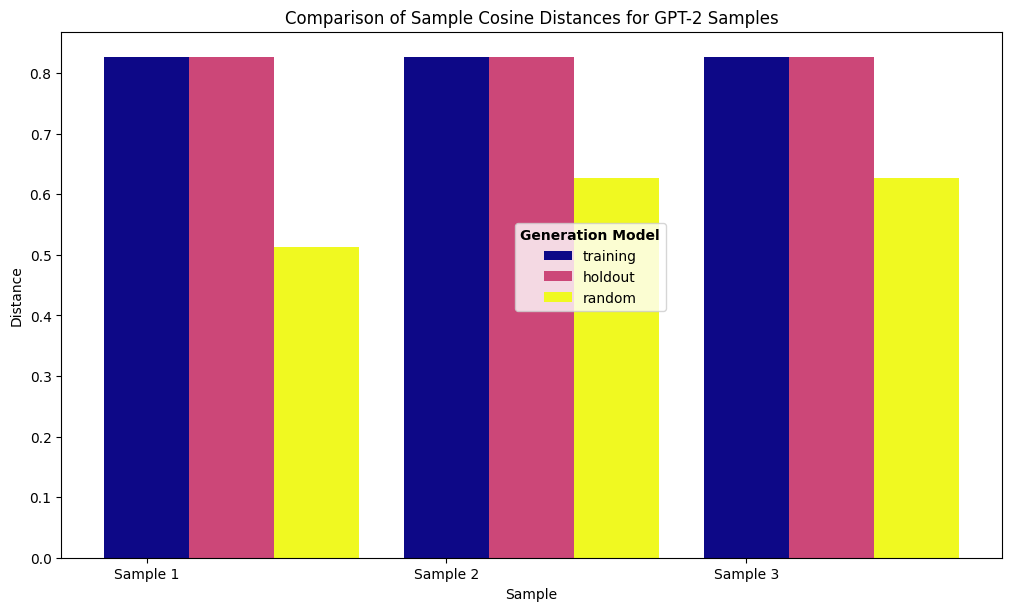

In [134]:
plot_sample_distances_by_prompt_length(privacy_gpt.model_privacy['prompt_based_il'],
                                       bbox_to_anchor=(0.65, 0.65),
                                       cmap='plasma',
                                       title='Comparison of Sample Cosine Distances for GPT-2 Samples',
                                       x_ticks=[f'Sample {i+1}' for i in range(len(privacy_gpt.model_privacy['prompt_based_il']['training'][0]))],
                                       save_path=f'figures/generated_data/distances/distances_GPT2_comparison',
                                       plot_error_bar=True)

In [127]:
print('Starting prompt-based information leakage attack...')
privacy_gpt.prompt_based_il_attack(rounds=3, return_avg=False, 
                                   prompt_types=['training', 'holdout', 'random'], 
                                   extract_features=True,
                                   custom=False)

# print('Starting prompt-length based information leakage attack...')
# privacy_gpt.prompt_length_il_attack(max_prompt_length=5, rounds=3, return_avg=False, extract_features=False)


Starting prompt-based information leakage attack...
Extracting feature-based distances using cosine metric...


Prompting for training data:   0%|          | 0/3 [00:00<?, ?it/s, Generating sample 1]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for training data:   0%|          | 0/3 [00:26<?, ?it/s, Generating sample 2]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for training data:   0%|          | 0/3 [00:49<?, ?it/s, Generating sample 3]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for holdout data:  33%|███▎      | 1/3 [01:12<02:25, 72.52s/it, Generating sample 1] 

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for holdout data:  33%|███▎      | 1/3 [01:36<02:25, 72.52s/it, Generating sample 2]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for holdout data:  33%|███▎      | 1/3 [02:00<02:25, 72.52s/it, Generating sample 3]

Generating on cpu
Prompting with 22:16056839:C>T_0|0


Prompting for random data:  67%|██████▋   | 2/3 [02:25<01:12, 72.76s/it, Generating sample 1] 

Generating on cpu
Prompting with 22:6383383:TGC/C>TTGC_0|1


Prompting for random data:  67%|██████▋   | 2/3 [02:54<01:12, 72.76s/it, Generating sample 2]

Generating on cpu
Prompting with 22:6383383:TGC/C>TTGC_0|1


Prompting for random data:  67%|██████▋   | 2/3 [03:26<01:12, 72.76s/it, Generating sample 3]

Generating on cpu
Prompting with 22:6383383:TGC/C>TTGC_0|1


Prompting for random data: 100%|██████████| 3/3 [03:54<00:00, 78.27s/it, Generating sample 3]


3
[[0.0016184898177975526, 0.0016184898177975526, 0.0006206643995873007]]
[[9.13050696367268e-05, 0.0017199306037313233, 0.0005503744052592907]]
[[0.7588267917475483, 0.7778276229677288, 0.7778276229677288]]


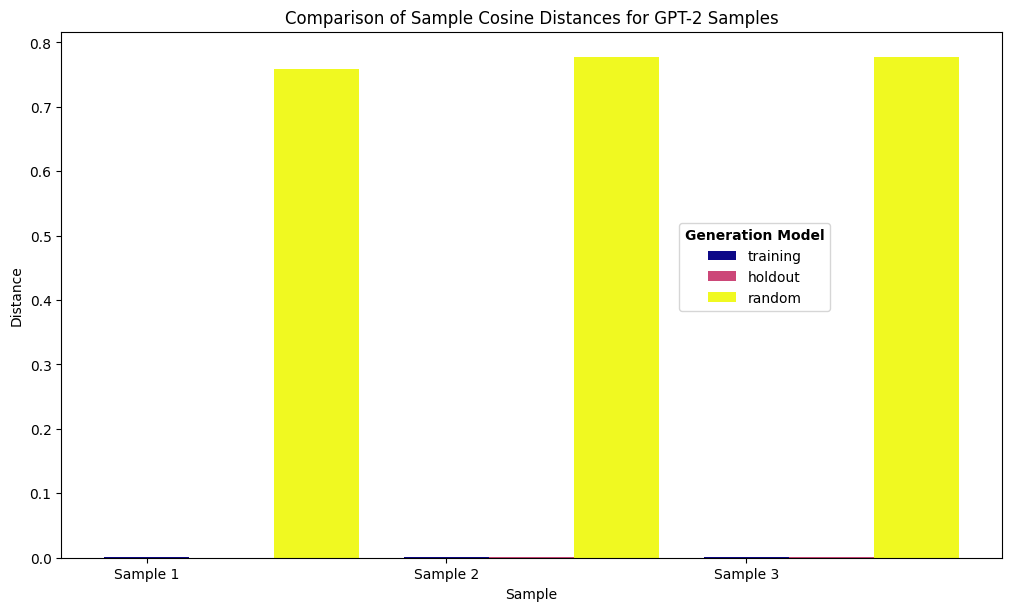

In [132]:
plot_sample_distances_by_prompt_length(privacy_gpt.model_privacy['prompt_based_il'],
                                       bbox_to_anchor=(0.65, 0.65),
                                       cmap='plasma',
                                       title='Comparison of Sample Cosine Distances for GPT-2 Samples',
                                       x_ticks=[f'Sample {i+1}' for i in range(len(privacy_gpt.model_privacy['prompt_based_il']['training'][0]))],
                                       save_path=f'figures/generated_data/distances/distances_GPT2_comparison_features',
                                       plot_error_bar=True)

## 3.B MIA

In [210]:
train_seq, test_seq = get_train_test_sequences(num_samples=20)
train_seq_high_risk, test_seq_high_risk = get_train_test_sequences(test_high_risk=True,
                                                                   num_samples=20)

### 3.2.a Without DP

In [173]:
tokenizer = AutoTokenizer.from_pretrained(saved_gpt2)
gpt_model = AutoModelForCausalLM.from_pretrained(saved_gpt2,
                                                # load_in_4bit=True,
                                                device_map="cpu")
tokenizer.pad_token = tokenizer.eos_token
# tokenizer.pad_token_id = 50256 # for open-ended generation

Extracting model-based features from 20 samples: 100%|██████████| 20/20 [29:07<00:00, 87.38s/it, Calculating Metrics]                 


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 23.34it/s]


Attacks Results: Risk Level: MODERATE (Max AUC=0.7750)
- THRESHOLD: AUC=0.7175, Accuracy=0.7250, Precision=0.7302, Recall=0.7250, F-Score=0.7234
- LOGISTIC: AUC=0.7700, Accuracy=0.6500, Precision=0.6648, Recall=0.6500, F-Score=0.6419
- RF: AUC=0.7550, Accuracy=0.6500, Precision=0.7000, Recall=0.6500, F-Score=0.6267
- KNN: AUC=0.7750, Accuracy=0.7000, Precision=0.7381, Recall=0.7000, F-Score=0.6875



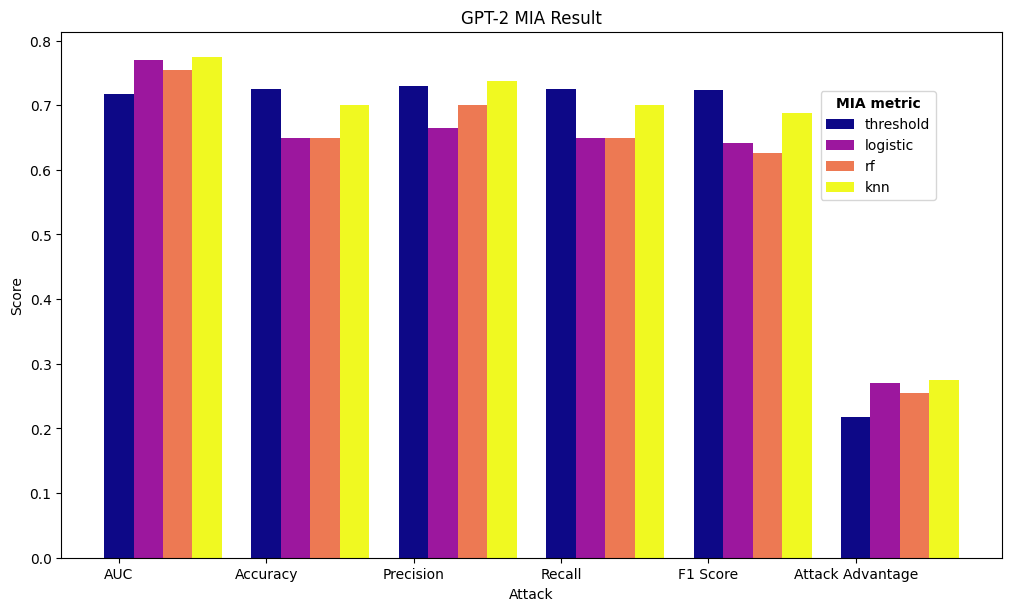

In [216]:
results_gpt = run_blackbox_mia(gpt_model, tokenizer, train_seq, test_seq, 
                           include_genomic_features=False,
                           title="GPT-2 MIA Result")
# results_gpt_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, 
#                             include_genomic_features=False,
#                             title="GPT-2 DP MIA Results")
# plot_mia_comparison(results_gpt, results_gpt_dp, eps=eps)

Extracting hybrid features from 20 samples:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting hybrid features from 20 samples: 100%|██████████| 20/20 [32:28<00:00, 97.42s/it, Getting Mutation Features from prompt 22:16056839:C>T_0|0 22:16059249:G>A_0|0] 


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 19.81it/s]

Attacks Results: Risk Level: HIGH (Max AUC=0.8100)
- THRESHOLD: AUC=0.7175, Accuracy=0.7250, Precision=0.7302, Recall=0.7250, F-Score=0.7234
- LOGISTIC: AUC=0.8100, Accuracy=0.8500, Precision=0.8535, Recall=0.8500, F-Score=0.8496
- RF: AUC=0.6100, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.4949
- KNN: AUC=0.6900, Accuracy=0.7000, Precision=0.7381, Recall=0.7000, F-Score=0.6875



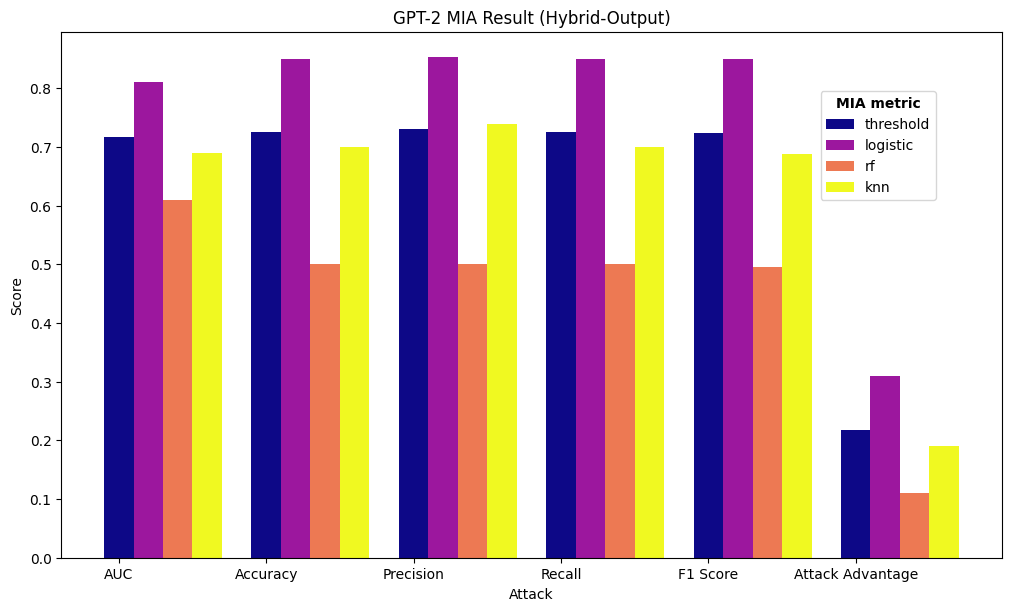

In [220]:
results_gpt_hybrid = run_blackbox_mia(gpt_model, tokenizer, train_seq, test_seq, 
                           include_genomic_features=True,
                           title="GPT-2 MIA Result (Hybrid-Output)")
# results_gpt_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, 
#                             include_genomic_features=False,
#                             title="GPT-2 DP MIA Results")
# plot_mia_comparison(results_gpt, results_gpt_dp, eps=eps)

Extracting model-based features from 20 samples: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it, Calculating Metrics]             


Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 28.21it/s]


Attacks Results: Risk Level: LOW-MODERATE (Max AUC=0.5700)
- THRESHOLD: AUC=0.4550, Accuracy=0.6250, Precision=0.7165, Recall=0.6250, F-Score=0.5807
- LOGISTIC: AUC=0.5700, Accuracy=0.4500, Precision=0.4495, Recall=0.4500, F-Score=0.4486
- RF: AUC=0.4200, Accuracy=0.4000, Precision=0.3958, Recall=0.4000, F-Score=0.3939
- KNN: AUC=0.4200, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.4505



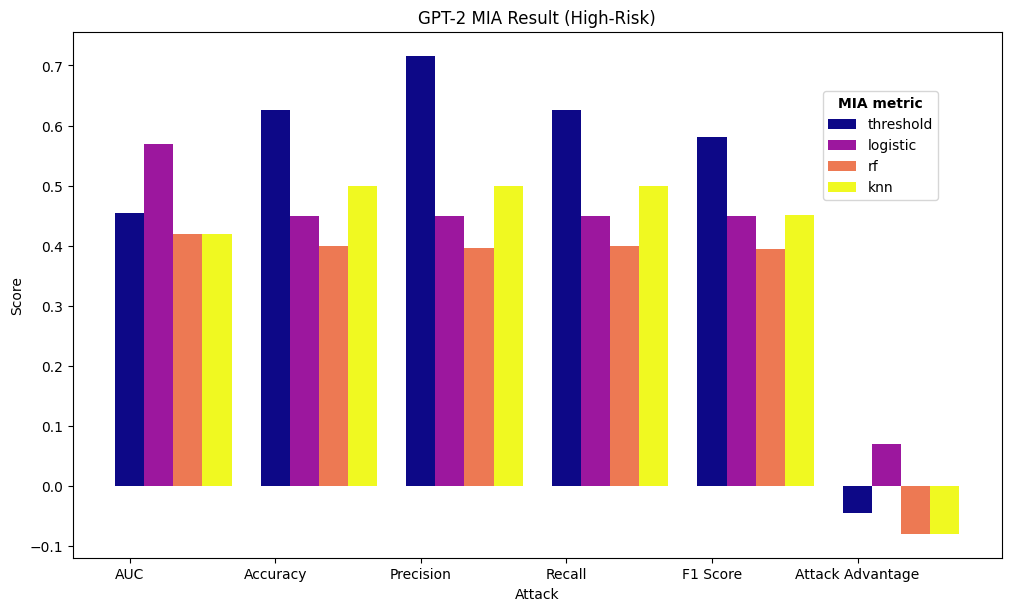

In [217]:
results_gpt_high_risk = run_blackbox_mia(gpt_model, tokenizer, train_seq_high_risk, test_seq_high_risk, 
                           include_genomic_features=False,
                           title="GPT-2 MIA Result (High-Risk)")
# results_gpt_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, 
#                             include_genomic_features=False,
#                             title="GPT-2 DP MIA Results")
# plot_mia_comparison(results_gpt, results_gpt_dp, eps=eps)

Extracting hybrid features from 20 samples:  15%|█▌        | 3/20 [00:14<01:13,  4.30s/it, Processing tokens (0 to 1024)]                                                    

Error processing sequence 2: index out of range in self


Extracting hybrid features from 20 samples:  20%|██        | 4/20 [00:16<00:55,  3.46s/it, Processing tokens (0 to 1024)]                                                

Error processing sequence 3: index out of range in self


Extracting hybrid features from 20 samples:  35%|███▌      | 7/20 [00:29<00:51,  3.93s/it, Processing tokens (0 to 1024)]                                                

Error processing sequence 6: index out of range in self


Extracting hybrid features from 20 samples:  30%|███       | 6/20 [00:21<00:45,  3.23s/it, Processing tokens (0 to 1024)]                                                 

Error processing sequence 5: index out of range in self


Extracting hybrid features from 20 samples:  40%|████      | 8/20 [00:28<00:39,  3.25s/it, Processing tokens (0 to 1024)]                                                

Error processing sequence 7: index out of range in self


Extracting hybrid features from 20 samples:  90%|█████████ | 18/20 [01:06<00:06,  3.48s/it, Processing tokens (0 to 1024)]                                                

Error processing sequence 17: index out of range in self


Extracting hybrid features from 20 samples:  95%|█████████▌| 19/20 [01:08<00:03,  3.18s/it, Processing tokens (0 to 1024)]                                                

Error processing sequence 18: index out of range in self


Extracting hybrid features from 20 samples: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it, Getting Mutation Features from prompt 22:17352975:T>C_0|1 22:17363543:C>T_1|0]


Error processing sequence 19: index out of range in self
Running threshold attack...


Running knn attack...: 100%|██████████| 3/3 [00:00<00:00, 22.54it/s]

Attacks Results: Risk Level: LOW (Max AUC=0.4800)
- THRESHOLD: AUC=0.4587, Accuracy=0.6250, Precision=0.7165, Recall=0.6250, F-Score=0.5807
- LOGISTIC: AUC=0.3900, Accuracy=0.4500, Precision=0.4495, Recall=0.4500, F-Score=0.4486
- RF: AUC=0.4800, Accuracy=0.5000, Precision=0.5000, Recall=0.5000, F-Score=0.4949
- KNN: AUC=0.3750, Accuracy=0.4500, Precision=0.4020, Recall=0.4500, F-Score=0.3732



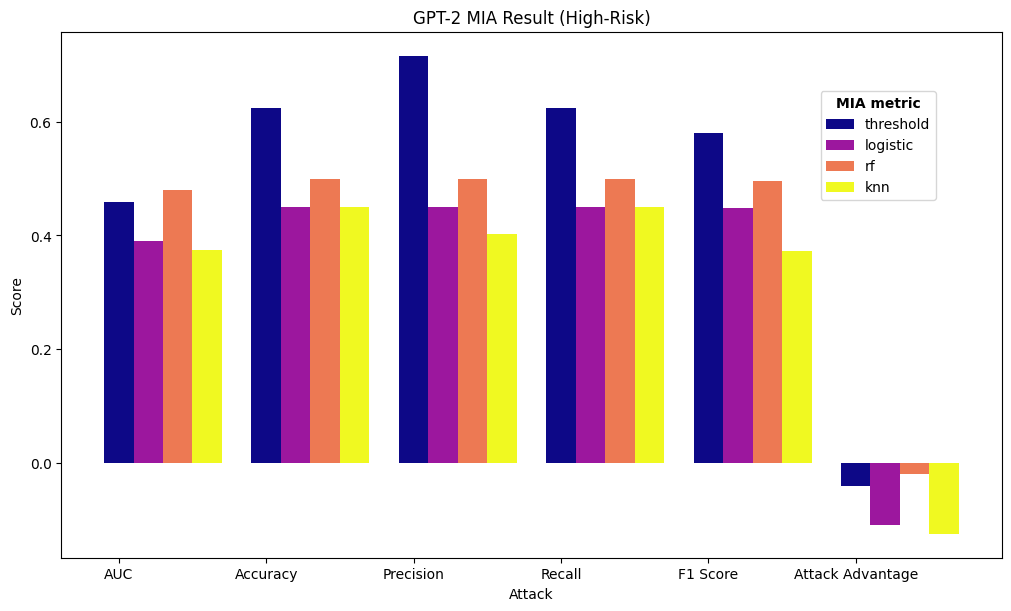

In [221]:
results_gpt_hybrid_high_risk = run_blackbox_mia(gpt_model, tokenizer, train_seq_high_risk, test_seq_high_risk, 
                           include_genomic_features=True,
                           title="GPT-2 MIA Result (High-Risk)")
# results_gpt_dp = run_blackbox_mia(mingpt_dp, regex_tokenizer, train_seq, test_seq, 
#                             include_genomic_features=False,
#                             title="GPT-2 DP MIA Results")
# plot_mia_comparison(results_gpt, results_gpt_dp, eps=eps)